<a target="_blank" href="https://colab.research.google.com/github/ginal001/ML-2024-2025/blob/main/Lab9/Homework09.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# MNIST dataset
----------------------

In this workshop, we will construct an MLP network designed to a specific task of classification of MNIST dataset: a set of handwritten digits from *zero* to *nine*. MNIST stands for Modified National Institute of Standards and Technology database.

**You can read more about this dataset [here](https://colah.github.io/posts/2014-10-Visualizing-MNIST/#MNIST).**




# Multi Layer Perceptron Notation
---------------------------------

In this workshop we will be classifying 28 by 28 images into 10 classes. Thus, a four layer perceptron (our classificator) we will work further with can be defined as
$\hat f:\mathbb{R}^{28\cdot 28} \rightarrow \mathbb{R}^{10}$ defined as

$$\hat f \left(x; W_1, W_2, W_3, W_4, b_1, b_2, b_3, b_4 \right) =  W_4 \left[ W_3 \left[ W_2 \left[ W_1 x  + b_1 \right]_+  + b_2 \right]_+  + b_3 \right]_+ + b_4,$$

where matrices $W_1, \ldots, W_4$ are tensors of order two (matrices) with matching dimensions and bias terms $b_1, \ldots, b_4$ are tensors of order one (vectors) of matching dimensions, and we are using ReLU activation.

Note, that there is no nonlinear activation after the last layer in our neural network. **There is an implicit softmax applied while cross entropy loss is calculated by `torch.nn.functional`.**


# Reading MNIST Dataset to Play with It
--------------------

In [1]:
import torch
import torchvision
from matplotlib import pyplot

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=None)

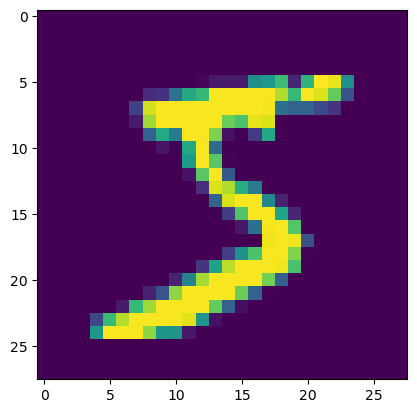

In [2]:
train_image, train_target = trainset[0]    #let us examine the 0-th sample
pyplot.imshow(train_image)
pyplot.show()

In [3]:
trainset.data[0]     #it will be shown in two rows, so a human has hard time classificating it

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [4]:
trainset[0][1]    #check if you classified it correctly in your mind

5

# Rereading the MNIST Data (Serious Preparation for Training)
------------------

In [5]:
(trainset.data.numpy().mean()/255.0, trainset.data.numpy().std()/255.0)   #MNIST datapoints are RGB integers 0-255

(np.float64(0.1306604762738429), np.float64(0.30810780385646264))

# Task
---------------

Why do we need to normalize the data, and not feed the NN with the 0-255 integers?

In [6]:
transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(), #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

## Visualizing Data


### Labels (Ground Truth Outputs)

In [7]:
for i, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        if i<5:
            print(i, "-th batch labels :", batch_labels)

0 -th batch labels : tensor([3, 4, 9,  ..., 0, 9, 5])
1 -th batch labels : tensor([2, 1, 7,  ..., 3, 2, 4])
2 -th batch labels : tensor([9, 7, 6,  ..., 7, 3, 3])
3 -th batch labels : tensor([4, 4, 9,  ..., 9, 5, 8])
4 -th batch labels : tensor([7, 2, 5,  ..., 0, 5, 0])


A single label is an entity of order zero (a constant), but batched labels are of order one. The first (and only) index is a sample index within a batch.

### Inputs

In [8]:
for i, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        if i==0:
            print(i, "-th batch inputs :", batch_inputs)

0 -th batch inputs : tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
     

OK, so each data image was initially a two dimensional image when we first saw it, but now the batches have order 4. The first index is a sample index within a batch, but a second index is always 0. This index represents a Channel number inserted here by `ToTensor()` transformation, always 0. As this order is one-dimensional, we can get rid of it, later, in training, in `Flatten` layer or by using `squeeze()` on a tensor.

# MLP Definition
-----------------

Your job now is to take the (fully functional) definition of the MLP structure and get rid off the Sequential layer.


In [9]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = torch.nn.Sequential(   #Sequential is a structure which allows stacking layers one on another in such a way,
                                          #that output from a preceding layer serves as input to the next layer
            torch.nn.Flatten(),   #change the last three orders in data (with dimensions 1, 28 and 28 respectively) into one order of dimensions (1*28*28)
            torch.nn.Linear(1*28*28, 1024),  #which is used as INPUT to the first Linear layer
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 2048),   #IMPORTANT! Please observe, that the OUTPUT dimension of a preceding layer is always equal to the INPUT dimension of the next layer.
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 256),
            torch.nn.ReLU(),            #ReLU (or a Sigmoid if you want) is a nonlinear function which is used in-between layers
            torch.nn.Linear(256, 10),
        )
        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):
        x = self.mlp(x)
        x = self.dropout(x)
        return x

# Training Loop
----------------------

In [10]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = MLP().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)   #initial and fixed learning rate of 0.001.

net.train()    #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing traning
for epoch in range(8):  #  an epoch is a training run through the whole data set

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)  #explicitly moving the data to the target device
        batch_labels = batch_labels.to(device)

        #batch_inputs.squeeze(1)     #alternatively if not for a Flatten layer, squeeze() could be used to remove the second order of the tensor, the Channel, which is one-dimensional (this index can be equal to 0 only)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)   #this line calls the forward(self, x) method of the MLP object. Please note, that the last layer of the MLP is linear
                                            #and MLP doesn't apply
                                            #the nonlinear activation after the last layer
        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean") #instead, nonlinear softmax is applied internally in THIS loss function
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()       #this computes gradients as we have seen in previous workshops
        optimizer.step()     #but this line in fact updates our neural network.
                                ####You can experiment - comment this line and check, that the loss DOE

Working on cuda
epoch: 0 batch: 0 current batch loss: 2.303171157836914
epoch: 0 batch: 1 current batch loss: 2.0451552867889404
epoch: 0 batch: 2 current batch loss: 1.5635595321655273
epoch: 0 batch: 3 current batch loss: 1.0015549659729004
epoch: 0 batch: 4 current batch loss: 1.1757454872131348
epoch: 0 batch: 5 current batch loss: 1.2468087673187256
epoch: 0 batch: 6 current batch loss: 1.0330967903137207
epoch: 0 batch: 7 current batch loss: 0.7112107276916504
epoch: 0 batch: 8 current batch loss: 0.786727786064148
epoch: 0 batch: 9 current batch loss: 0.7364326119422913
epoch: 0 batch: 10 current batch loss: 0.573254406452179
epoch: 0 batch: 11 current batch loss: 0.563489556312561
epoch: 0 batch: 12 current batch loss: 0.5702142119407654
epoch: 0 batch: 13 current batch loss: 0.5446611642837524
epoch: 0 batch: 14 current batch loss: 0.5284438729286194
epoch: 0 batch: 15 current batch loss: 0.44555234909057617
epoch: 0 batch: 16 current batch loss: 0.4123386740684509
epoch: 0 ba

# Testing
----------------------

Correct the code below so it works.

In [11]:
good = 0
wrong = 0

net.eval()              #it notifies the network layers (especially batchnorm or dropout layers, which we don't use in this example) that we are doing evaluation
with torch.no_grad():   #it prevents that the net learns during evalution. The gradients are not computed, so this makes it faster, too
    for batch, data in enumerate(testloader): #batches in test are of size 1
        datapoint, label = data

        prediction = net(datapoint.to(device))                  #prediction has values representing the "prevalence" of the corresponding class
        classification = torch.argmax(prediction)    #the class is the index of maximal "prevalence"

        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

accuracy =  0.9815


# **Homework Assignment - *Do Androids Dream of Electric Sheep?***

-------------------------------------  

"Do Androids Dream of Electric Sheep?" – the famous title of Philip K. Dick’s novel – raises a fascinating question: if artificial intelligence could dream, what would it see?  

In this assignment, we explore a phenomenon known as **neural network dreams**, where instead of optimizing a neural network's weights, we **optimize the input itself** to achieve a desired classification outcome. Given a fully trained MNIST classification network, your goal is to manipulate its inputs so that it confidently predicts each digit from 0 to 9, starting from pure noise.  

## **Tasks Description**  

During this class we designed and trained a **MNIST classification neural network**, which takes a **batch of grayscale images** of size **$28 \times 28$** as input and outputs a probability distribution over the 10 digit classes (0–9). However, instead of using real MNIST images, you will **treat the input batch itself as a set of trainable parameters** and optimize it so that the network classifies each image as a specific digit.  

1. Your first task is to generate **a batch of 10 images**, where each image is
   classified as one of the digits **0, 1, 2, ..., 9**, starting from an initial batch of ten random Gaussian noise images.  

   Discuss the following question: do the generated images resemble real MNIST digits? Why or why not?  

2. Discuss, how you would approach a second task of
   generating an image that   
   bares similarity to two or more digits simultaneously. **Implement your idea to see the results.**

3. Third task: repeat the previous tasks with an additional L2 penalty on noise within the images. Experiment with adding `lambda_l2 * dreamed_input_batch.pow(2).mean()` loss term, with `lambda_l2` being the penalty cooefficient within an exponential progression, say from 0.001 to 10.0. Are the new digits recognized correctly? How does the penalty impact the digit quality? Explain.

### **Optimization Process for Task 1**  

1. Start with a **batch of 10 random Gaussian noise images** as the initial input and $(0, 1, 2, \ldots, 9)$ as the expected output batch of target digits.  
2. Define the objective: maximize the neural network's confidence for the corresponding target digit for each image in the batch.  
3. Use **gradient descent** to modify the pixels in each image, making the network classify each one as the assigned digit.  
4. Repeat until the network assigns suffieciently high confidence to each image’s target class.  

### **Implementation Details**  

- The neural network weights **must remain frozen** during optimization. You are modifying only the input images.  
- The loss function should be the **cross-entropy loss** between the predicted probabilities and the desired class labels (plus an optional weighted L2 penalty regularizing the images in task 3).


## **Points to Note**  

1. **Visualize** the optimization process: Save images of the generated inputs at different steps and plot the classification confidence evolution over iterations.  
3. **Document your findings** and explain the behavior you observe.  

## **Task & Deliverables**  

- A **Colab notebook** containing solutions for both tasks:
  - The full implementation.
  - Visualizations of the generated batch of images.
  - A written explanation of your observations.
- **Bonus:** If you create an **animation** showing the evolution of the input images during optimization, it will be considered a strong enhancement to your submission.
  - You can generate an animation programmatically (e.g., using Matplotlib or OpenCV).
  - Or, save image frames and use external tools to create a video.
  - Provide a **link** to any video files in the README.
- Upload your notebook and results to your **GitHub repository** for the course.
- In the **README**, include a **link** to the notebook.
- In the notebook, include **“Open in Colab”** badge so it can be launched directly.




# Solution

# Creating numbers from training input

First, let’s define the function we’ll use to train the input. It will take a neural network and train the input until we reach our desired criteria (in our case, a classification probability above 0.99999 or 40_000 iterations). We also add an additional parameter, $\lambda$, which governs the penalty introduced earlier. It’s worth noting that we freeze the network’s parameters and train only the input points.

In [12]:
def plot_numbers(points):   #function for plotting trained points
    
    fig, axes = pyplot.subplots(1, 10, figsize=(15, 3))

    for i, ax in enumerate(axes):
        img = points[i].squeeze().detach().cpu().numpy()
        ax.imshow(img)      
        ax.set_title(f"{i}")            
        ax.axis('off')             

    pyplot.tight_layout()
    pyplot.show()



def train_input(net, lambda_l2 = 0, lr = 0.001, prob = 0.99999, plot = False, info = 2000, max_iter = 40000):   # main function
    
    net.eval()
    for parameters in net.parameters():
        parameters.requires_grad = False   # freezing model
    
    points = torch.randn(10, 1, 28, 28).to(device)
    points.requires_grad = True
    true = torch.LongTensor(range(0,10)).to(device)   # defining random noise and output
    
    optimizer = torch.optim.Adam([points], lr)

    epoch = 0
    
    while ( not all([torch.max(torch.nn.functional.softmax(net(points[number]), dim = 1)) > prob for number in range(0,10)]) ) and (epoch < max_iter):
    
        optimizer.zero_grad()
        preds = net(points)   
        loss = torch.nn.functional.cross_entropy(preds, true, reduction = "mean") + lambda_l2 * points.pow(2).mean()
    
        epoch += 1
        if epoch % info == 0:
            with torch.no_grad():
                print("Iteration", epoch, "current batch loss:", loss.item())
                print("Predicted value: ", [torch.argmax(torch.nn.functional.softmax(net(points[number]), dim = 1)).item() for number in range(0,10)], "\n", 
                  "Predicted probability: ", [round(torch.max(torch.nn.functional.softmax(net(points[number]), dim = 1)).item(), 6) for number in range(0,10)])
                if plot:
                    plot_numbers(points)
        
        loss.backward()     
        optimizer.step()     

    print("Iteration", epoch, "current batch loss:", loss.item())
    
    for parameters in net.parameters():
        parameters.requires_grad = True  # unfreezing model
        
    return points

# Case: $\lambda = 0$

Iteration 2000 current batch loss: 0.0014959226828068495
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.997909, 0.998884, 0.999462, 0.998729, 0.998261, 0.998587, 0.99882, 0.999174, 0.997355, 0.997874]


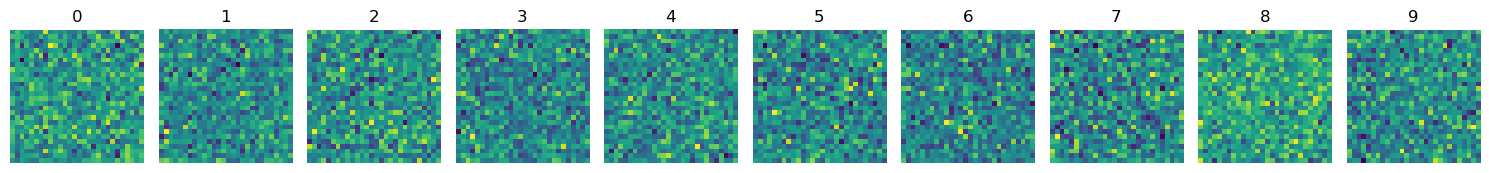

Iteration 4000 current batch loss: 0.00035105666029267013
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999533, 0.999763, 0.999872, 0.999726, 0.999554, 0.999691, 0.999722, 0.999808, 0.999321, 0.9995]


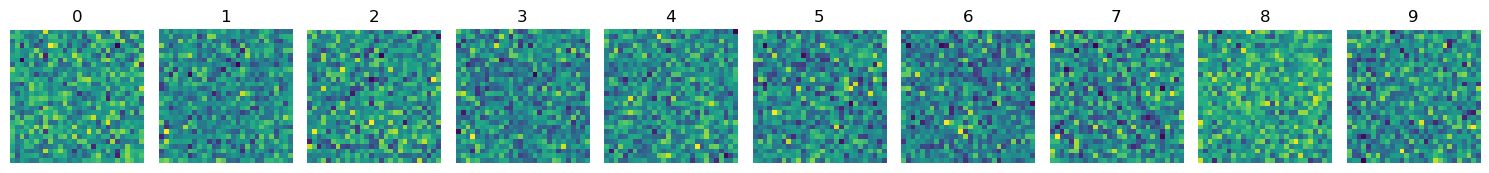

Iteration 6000 current batch loss: 0.00011383693345123902
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999848, 0.999929, 0.999957, 0.999918, 0.999843, 0.999906, 0.999907, 0.999939, 0.999775, 0.99984]


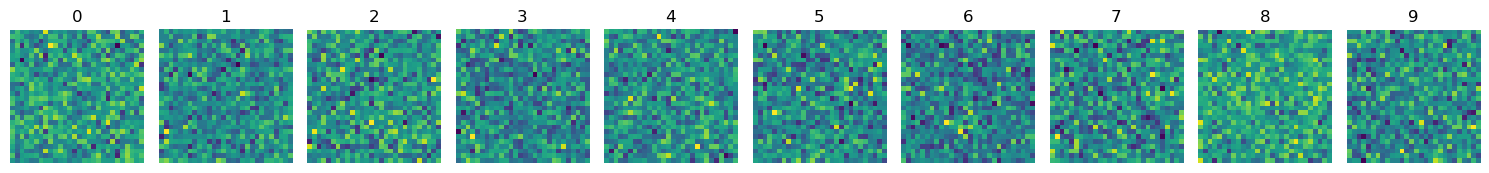

Iteration 8000 current batch loss: 4.072086449014023e-05
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999946, 0.999975, 0.999986, 0.999972, 0.999941, 0.999967, 0.999964, 0.999978, 0.999918, 0.999945]


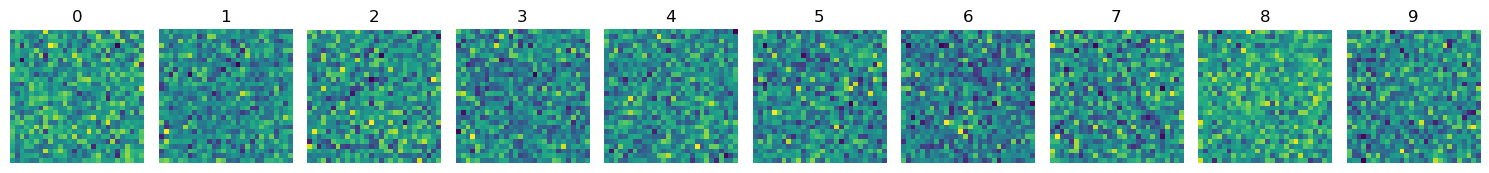

Iteration 10000 current batch loss: 1.4877179637551308e-05
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999981, 0.999991, 0.999995, 0.99999, 0.999977, 0.999987, 0.999986, 0.999992, 0.99997, 0.999981]


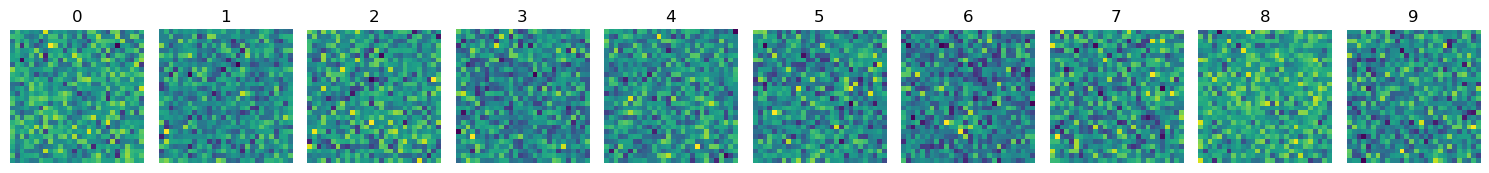

Iteration 12000 current batch loss: 5.424004484666511e-06
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999993, 0.999997, 0.999998, 0.999997, 0.999992, 0.999995, 0.999995, 0.999997, 0.999989, 0.999993]


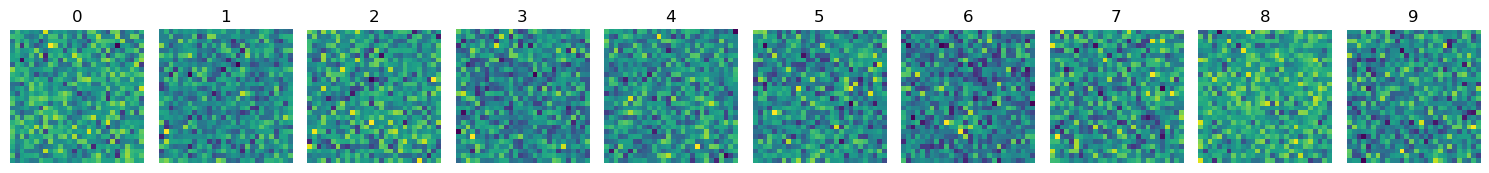

Iteration 12139 current batch loss: 5.0902208386105485e-06


In [13]:
points_1 = train_input(net, plot = True)

# Case: $\lambda = 0.001$

Iteration 2000 current batch loss: 0.0023436550982296467
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.998505, 0.99856, 0.998637, 0.999662, 0.998997, 0.999552, 0.998118, 0.998788, 0.997507, 0.998216]


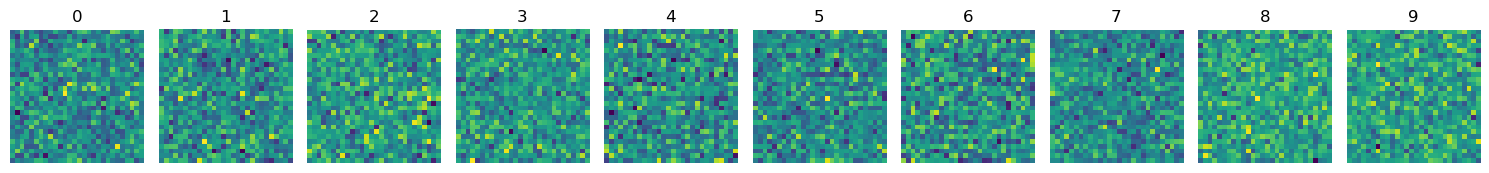

Iteration 4000 current batch loss: 0.0013136048801243305
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999659, 0.999674, 0.999714, 0.999917, 0.999747, 0.99989, 0.999564, 0.999714, 0.999399, 0.999572]


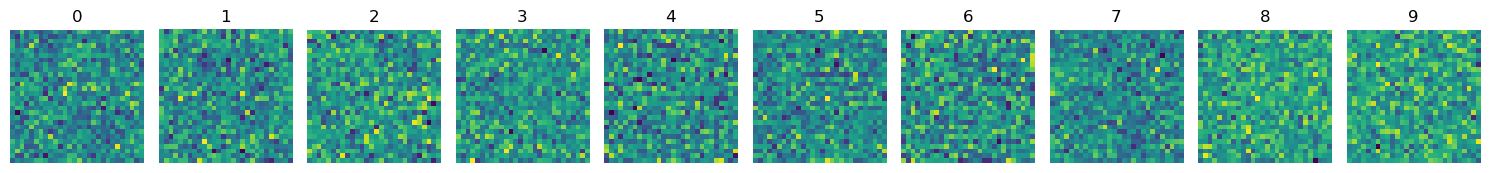

Iteration 6000 current batch loss: 0.001092722057364881
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999897, 0.999895, 0.999916, 0.99997, 0.999909, 0.999961, 0.999856, 0.999903, 0.999794, 0.99986]


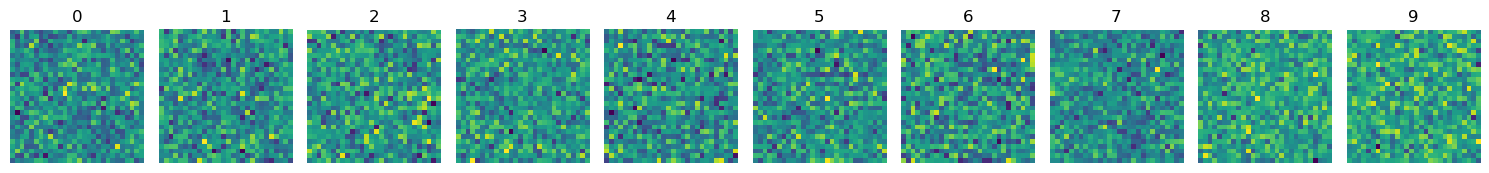

Iteration 8000 current batch loss: 0.0009941088501363993
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999961, 0.999962, 0.999971, 0.999987, 0.999963, 0.999984, 0.999946, 0.999964, 0.999917, 0.999947]


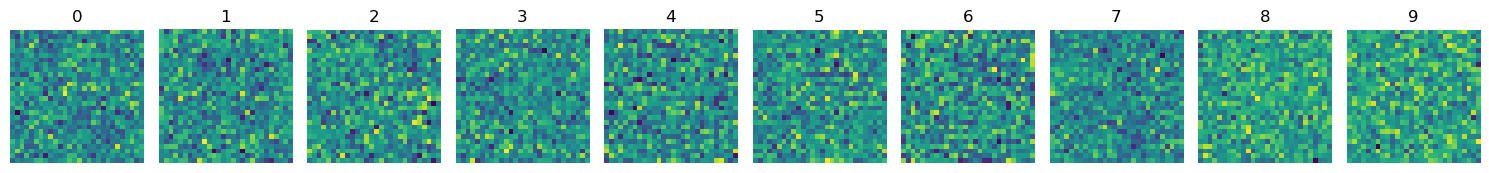

Iteration 10000 current batch loss: 0.000889306771568954
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999982, 0.999984, 0.999987, 0.999993, 0.999983, 0.999991, 0.999977, 0.999984, 0.999964, 0.999976]


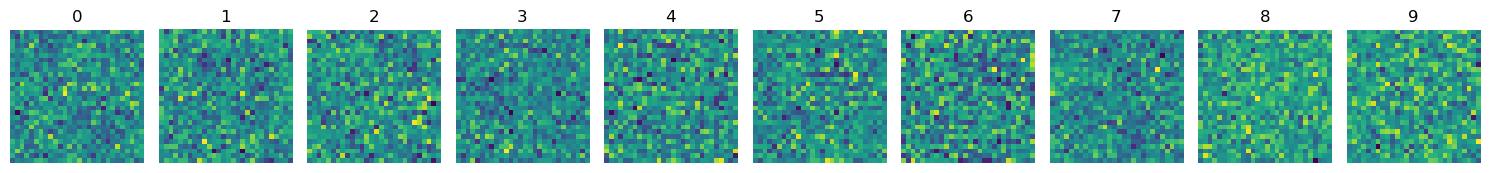

Iteration 12000 current batch loss: 0.0007245129090733826
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999989, 0.999991, 0.999992, 0.999995, 0.99999, 0.999994, 0.999987, 0.999991, 0.999982, 0.999986]


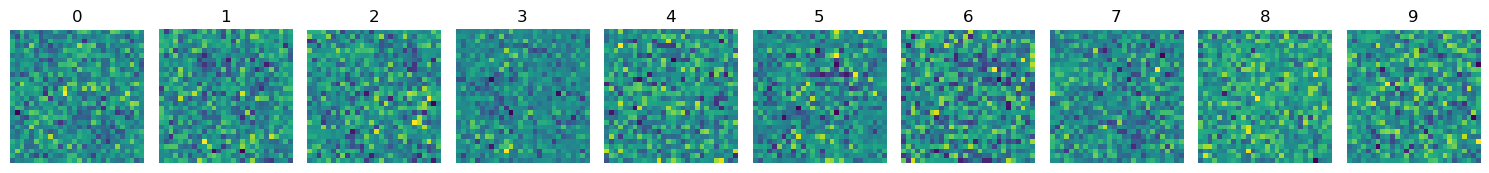

Iteration 14000 current batch loss: 0.0004932929878123105
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999991, 0.999993, 0.999993, 0.999996, 0.999993, 0.999995, 0.999991, 0.999993, 0.999988, 0.99999]


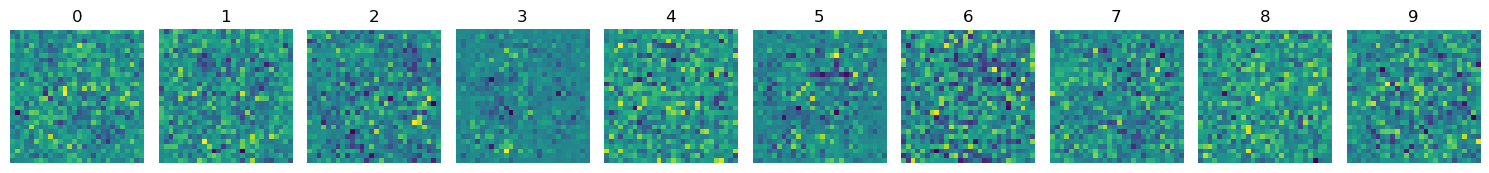

Iteration 16000 current batch loss: 0.00025421311147511005
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999993, 0.999994, 0.999995, 0.999996, 0.999994, 0.999995, 0.999993, 0.999995, 0.99999, 0.999993]


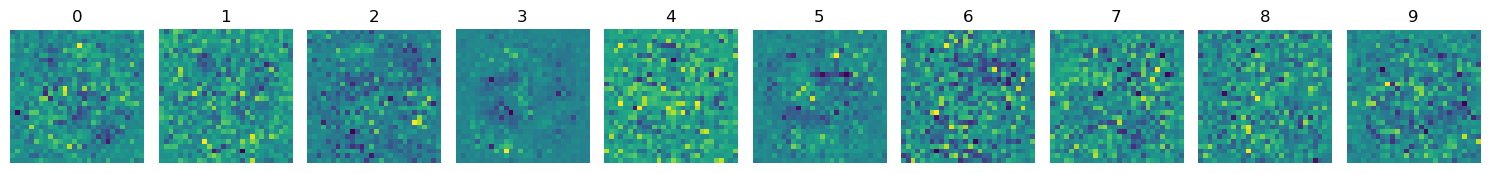

Iteration 16562 current batch loss: 0.0001989890733966604


In [14]:
points_2 = train_input(net, lambda_l2 = 0.001, plot = True)

# Case: $\lambda = 0.01$

Iteration 2000 current batch loss: 0.010494648478925228
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.998269, 0.998585, 0.998723, 0.99936, 0.998683, 0.999959, 0.99913, 0.998767, 0.998128, 0.998706]


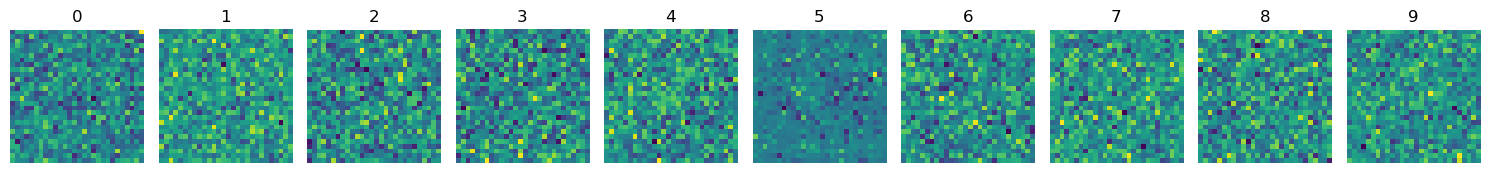

Iteration 4000 current batch loss: 0.009140078909695148
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999557, 0.999666, 0.999681, 0.999854, 0.999682, 0.999966, 0.999762, 0.999714, 0.999512, 0.999661]


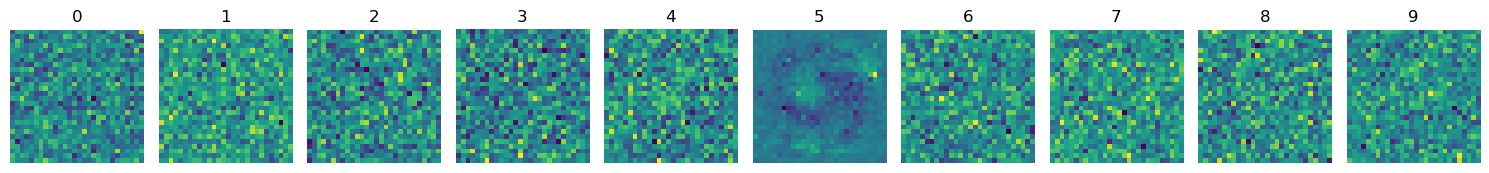

Iteration 6000 current batch loss: 0.008074917830526829
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99983, 0.999881, 0.999874, 0.999925, 0.999877, 0.999967, 0.999897, 0.999881, 0.999801, 0.999852]


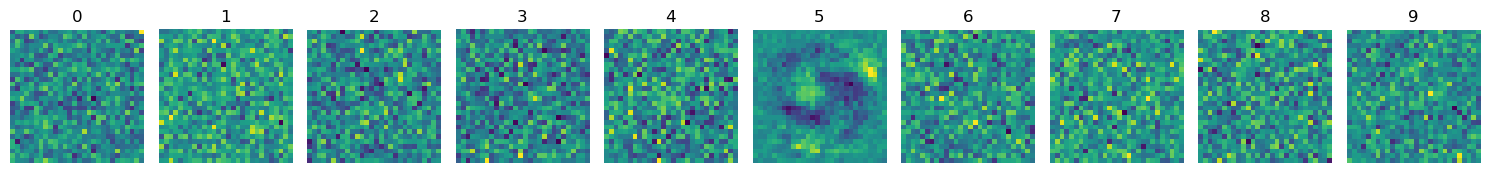

Iteration 8000 current batch loss: 0.006351654417812824
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999905, 0.999934, 0.99992, 0.999939, 0.999927, 0.999967, 0.999934, 0.999931, 0.999882, 0.999909]


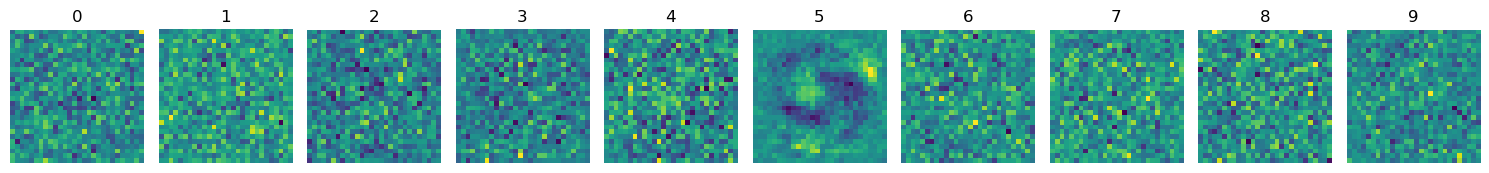

Iteration 10000 current batch loss: 0.0040067583322525024
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999926, 0.999951, 0.999935, 0.999953, 0.999943, 0.999967, 0.999943, 0.999952, 0.9999, 0.999931]


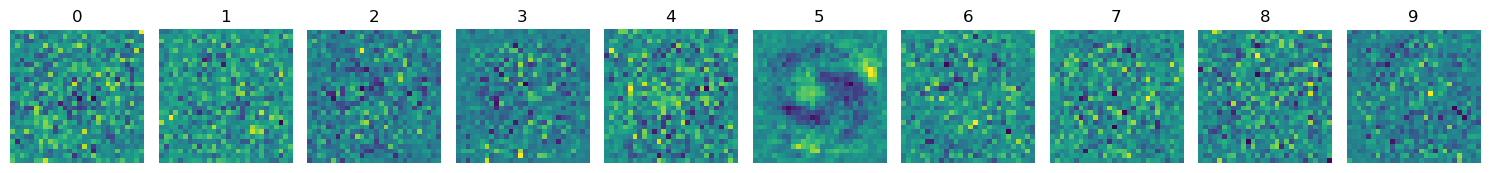

Iteration 12000 current batch loss: 0.0017965015722438693
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99994, 0.999956, 0.999947, 0.999963, 0.999948, 0.999967, 0.999947, 0.999963, 0.999913, 0.999944]


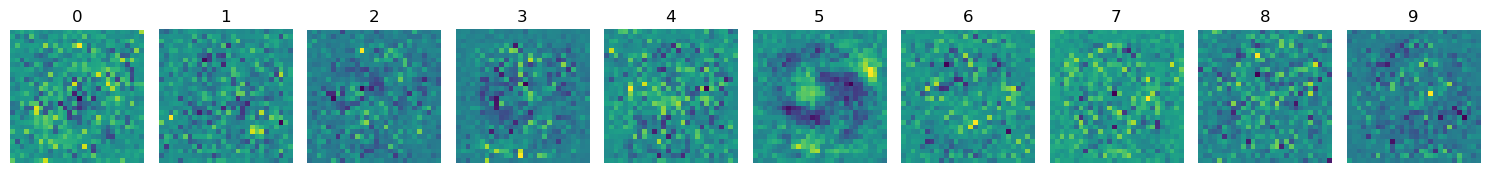

Iteration 14000 current batch loss: 0.0005934372311457992
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999948, 0.999962, 0.999959, 0.999966, 0.999956, 0.999967, 0.999951, 0.999968, 0.999924, 0.999951]


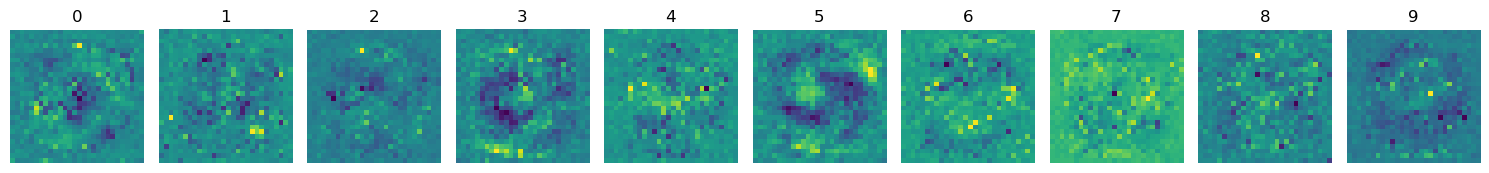

Iteration 16000 current batch loss: 0.0003096172877121717
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99995, 0.999962, 0.999962, 0.999967, 0.999957, 0.999967, 0.999954, 0.999969, 0.999931, 0.999952]


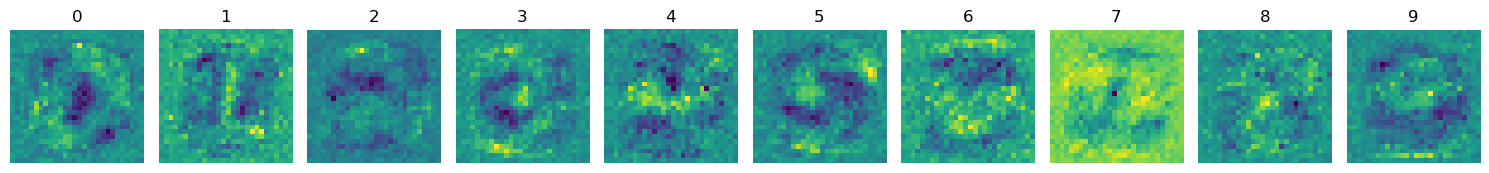

Iteration 18000 current batch loss: 0.00029383014771156013
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99995, 0.999962, 0.999963, 0.999967, 0.999957, 0.999967, 0.999954, 0.999969, 0.999931, 0.999952]


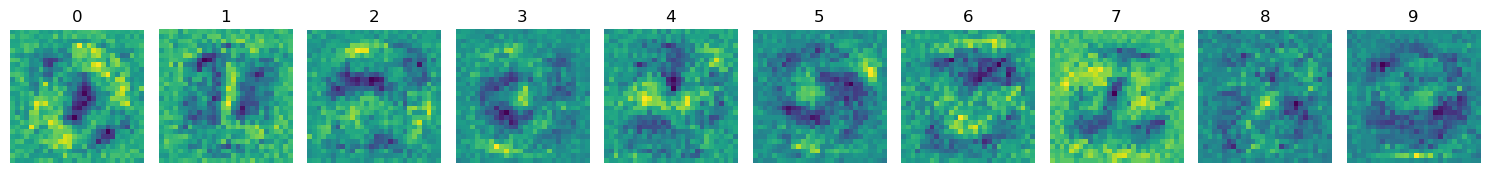

Iteration 20000 current batch loss: 0.0002934561052825302
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99995, 0.999962, 0.999963, 0.999967, 0.999957, 0.999967, 0.999954, 0.999968, 0.999931, 0.999952]


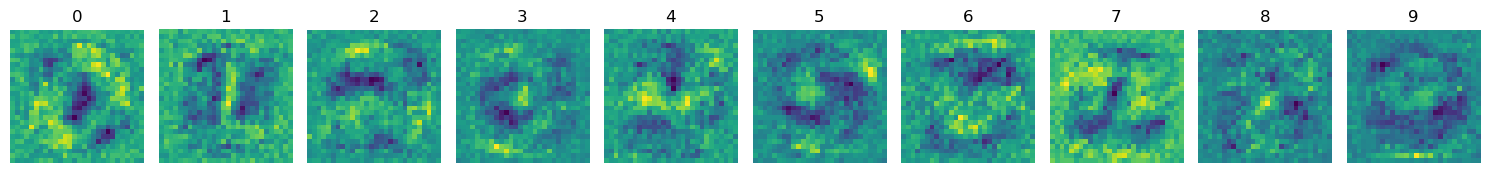

Iteration 22000 current batch loss: 0.0002934392250608653
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99995, 0.999962, 0.999963, 0.999967, 0.999957, 0.999967, 0.999954, 0.999968, 0.999931, 0.999952]


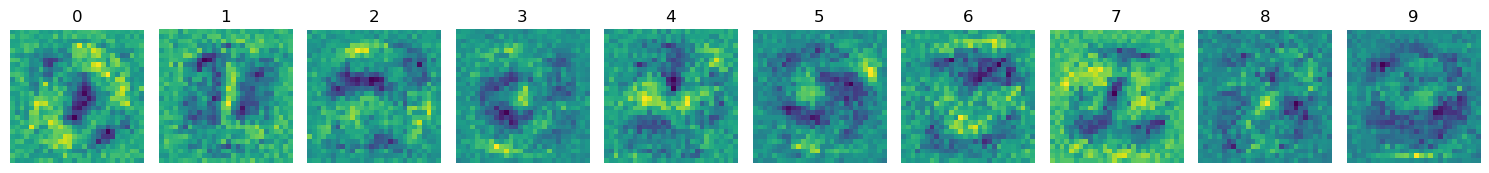

Iteration 24000 current batch loss: 0.0002934317453764379
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99995, 0.999962, 0.999963, 0.999967, 0.999957, 0.999967, 0.999954, 0.999969, 0.999931, 0.999952]


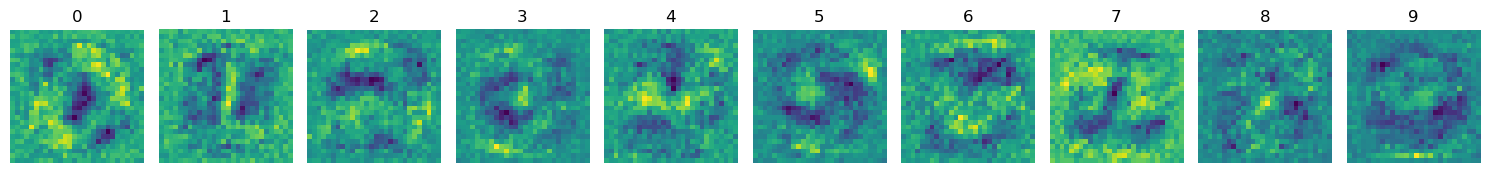

Iteration 26000 current batch loss: 0.0002934425137937069
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99995, 0.999962, 0.999963, 0.999967, 0.999957, 0.999967, 0.999954, 0.999969, 0.999931, 0.999952]


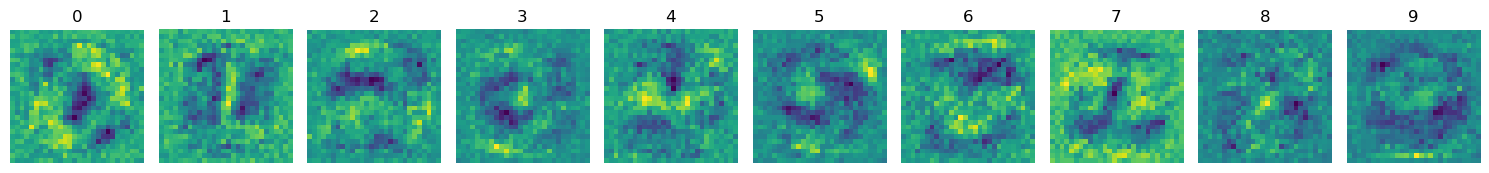

Iteration 28000 current batch loss: 0.00029342275229282677
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99995, 0.999962, 0.999963, 0.999967, 0.999957, 0.999967, 0.999954, 0.999969, 0.999931, 0.999952]


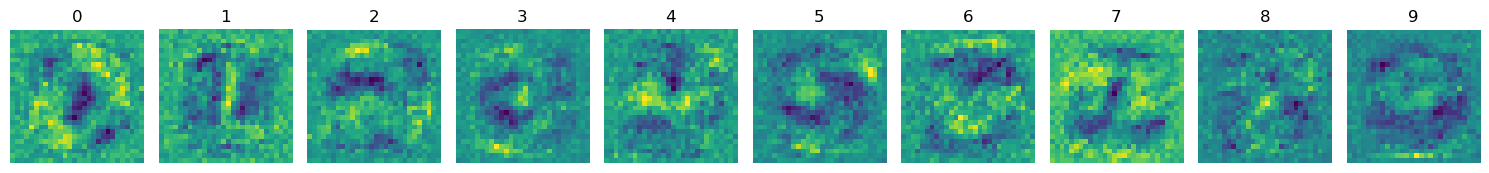

Iteration 30000 current batch loss: 0.00029344024369493127
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99995, 0.999962, 0.999963, 0.999967, 0.999957, 0.999967, 0.999954, 0.999968, 0.999931, 0.999952]


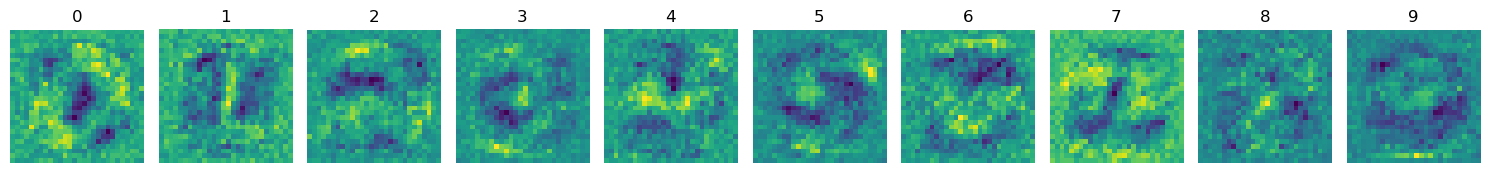

Iteration 32000 current batch loss: 0.0002934164949692786
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99995, 0.999962, 0.999963, 0.999967, 0.999957, 0.999967, 0.999954, 0.999969, 0.999931, 0.999952]


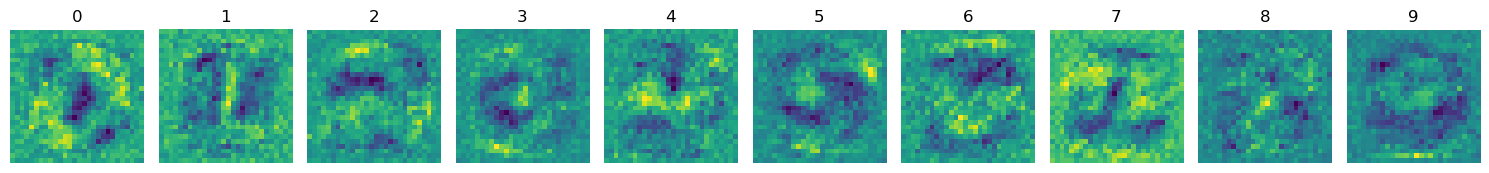

Iteration 34000 current batch loss: 0.0002934260410256684
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99995, 0.999962, 0.999963, 0.999967, 0.999957, 0.999967, 0.999954, 0.999969, 0.999931, 0.999952]


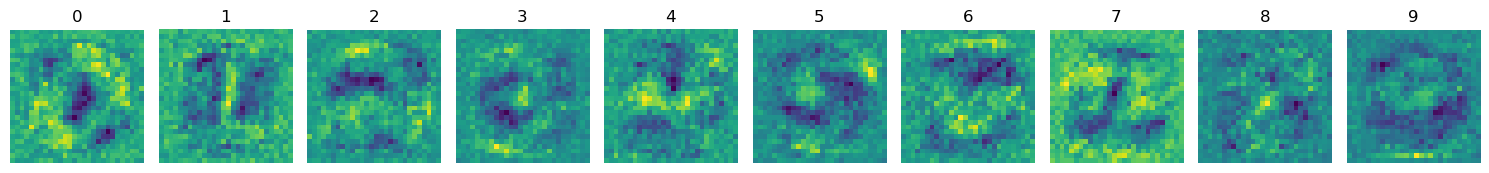

Iteration 36000 current batch loss: 0.0002934502554126084
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99995, 0.999962, 0.999963, 0.999967, 0.999957, 0.999967, 0.999954, 0.999969, 0.999931, 0.999952]


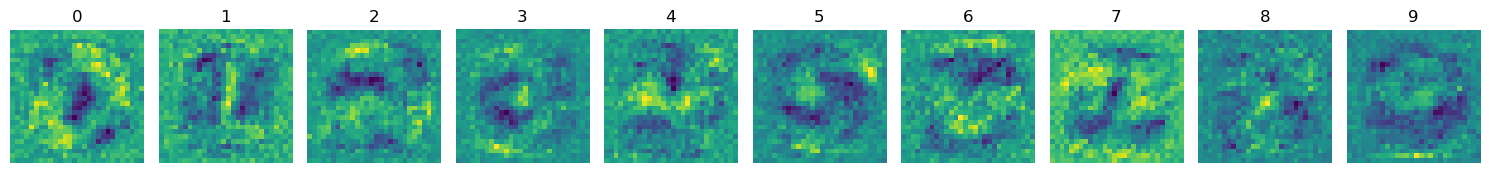

Iteration 38000 current batch loss: 0.00029340549372136593
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99995, 0.999962, 0.999963, 0.999967, 0.999957, 0.999967, 0.999954, 0.999969, 0.999931, 0.999952]


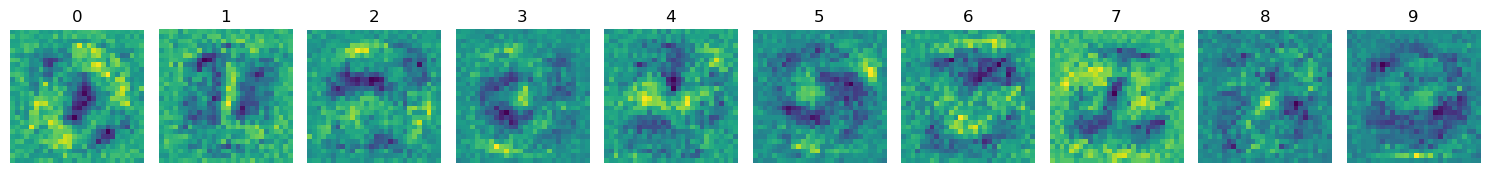

Iteration 40000 current batch loss: 0.0002934403601102531
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99995, 0.999962, 0.999963, 0.999967, 0.999957, 0.999967, 0.999954, 0.999968, 0.999931, 0.999952]


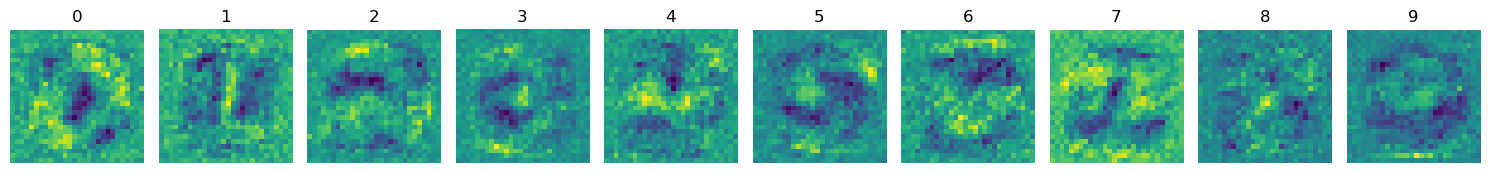

Iteration 40000 current batch loss: 0.0002934403601102531


In [15]:
points_3 = train_input(net, lambda_l2 = 0.01, plot = True)

# Case: $\lambda = 0.1$

Iteration 2000 current batch loss: 0.08813686668872833
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.998911, 0.998098, 0.998781, 0.998657, 0.99875, 0.998118, 0.997829, 0.999575, 0.998019, 0.997528]


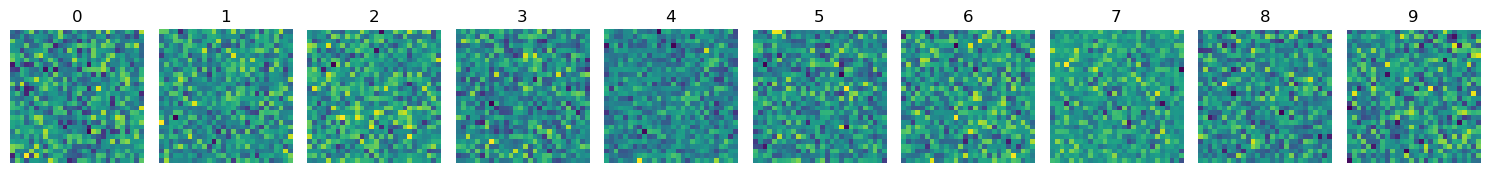

Iteration 4000 current batch loss: 0.062136728316545486
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999511, 0.999305, 0.999401, 0.999441, 0.999512, 0.999142, 0.999177, 0.999674, 0.999154, 0.999073]


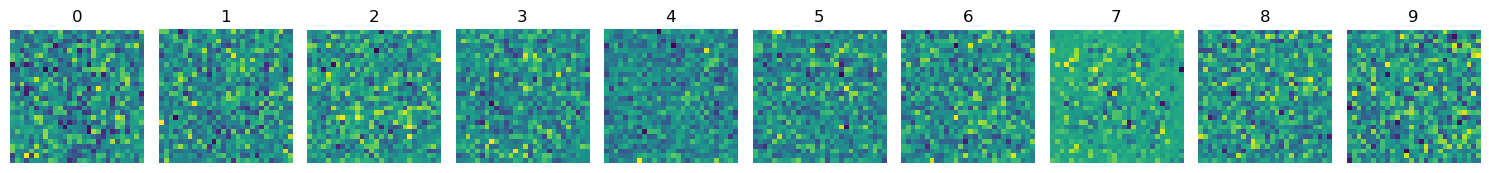

Iteration 6000 current batch loss: 0.03400087356567383
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999546, 0.999461, 0.999532, 0.999567, 0.999609, 0.999491, 0.999373, 0.999732, 0.99936, 0.999378]


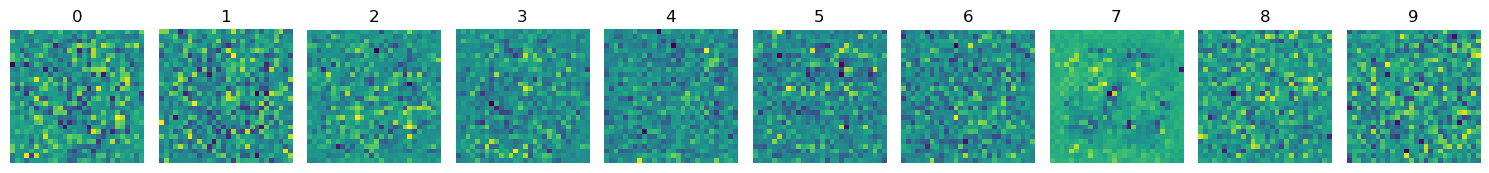

Iteration 8000 current batch loss: 0.0129545321688056
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.99956, 0.99962, 0.999651, 0.999696, 0.999641, 0.99966, 0.99951, 0.999739, 0.999409, 0.999492]


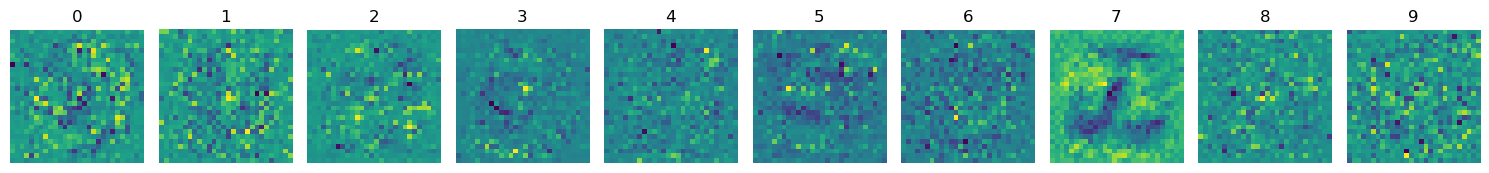

Iteration 10000 current batch loss: 0.0038974329363554716
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999579, 0.999679, 0.999691, 0.999726, 0.999661, 0.999716, 0.999593, 0.999741, 0.999447, 0.999577]


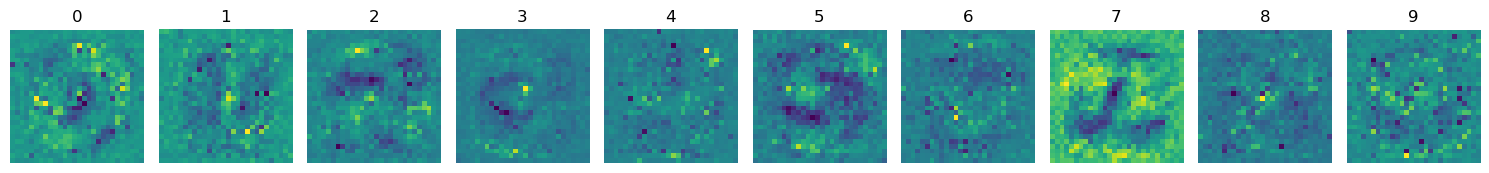

Iteration 12000 current batch loss: 0.002137612784281373
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999592, 0.999694, 0.999698, 0.999728, 0.999653, 0.99973, 0.999622, 0.999741, 0.99946, 0.999609]


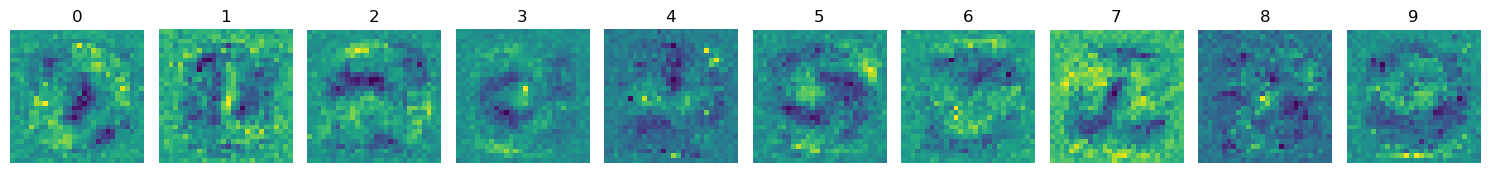

Iteration 14000 current batch loss: 0.0020302850753068924
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999595, 0.999694, 0.999699, 0.999728, 0.999651, 0.999731, 0.999627, 0.999741, 0.999461, 0.999613]


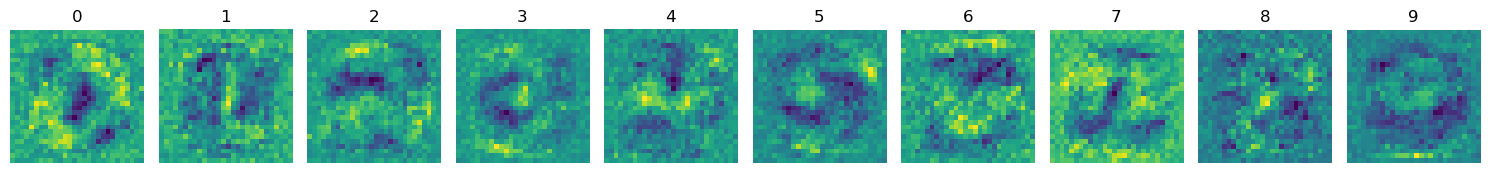

Iteration 16000 current batch loss: 0.0020290319807827473
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999595, 0.999694, 0.999699, 0.999728, 0.999651, 0.99973, 0.999627, 0.999741, 0.999461, 0.999613]


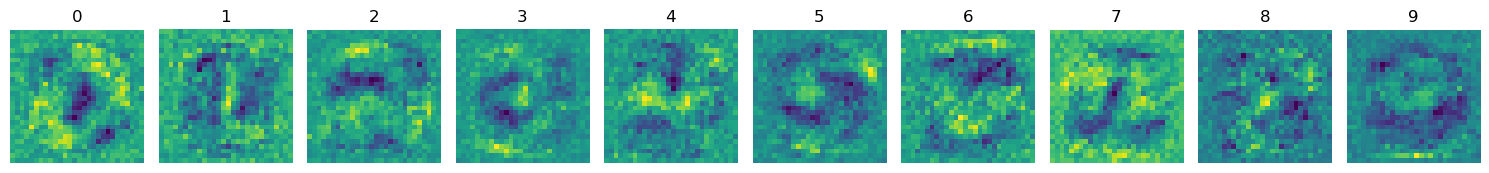

Iteration 18000 current batch loss: 0.0020291628316044807
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999595, 0.999694, 0.999699, 0.999728, 0.999651, 0.99973, 0.999627, 0.999741, 0.999461, 0.999613]


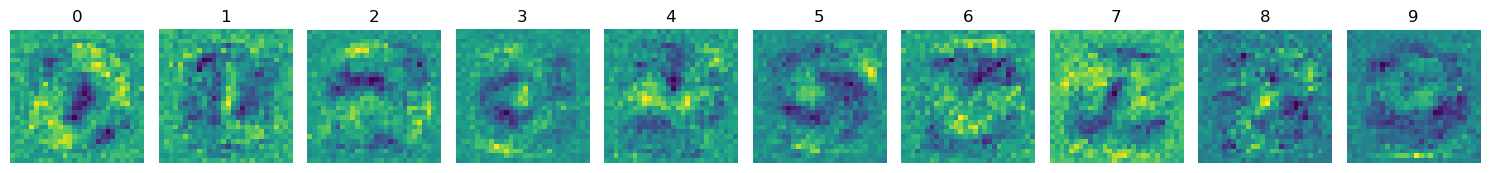

Iteration 20000 current batch loss: 0.002029201714321971
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999595, 0.999694, 0.999699, 0.999728, 0.999652, 0.99973, 0.999627, 0.999741, 0.999462, 0.999613]


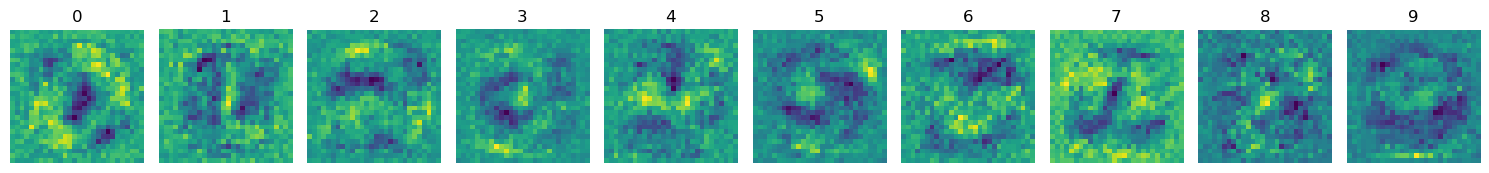

Iteration 22000 current batch loss: 0.002029145136475563
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999595, 0.999694, 0.999699, 0.999728, 0.999651, 0.99973, 0.999627, 0.999741, 0.999461, 0.999613]


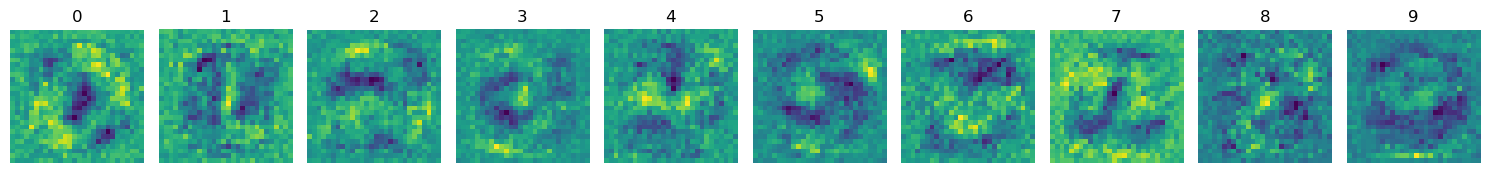

Iteration 24000 current batch loss: 0.0020292128901928663
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999595, 0.999694, 0.999699, 0.999728, 0.999652, 0.99973, 0.999627, 0.999741, 0.999461, 0.999613]


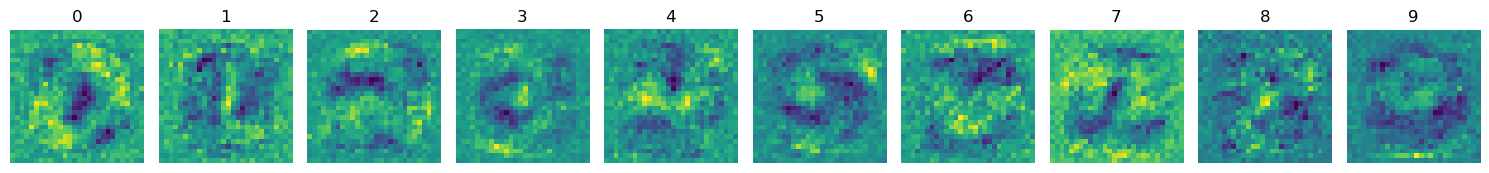

Iteration 26000 current batch loss: 0.002029141876846552
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999595, 0.999694, 0.999699, 0.999728, 0.999652, 0.999731, 0.999627, 0.999741, 0.999462, 0.999613]


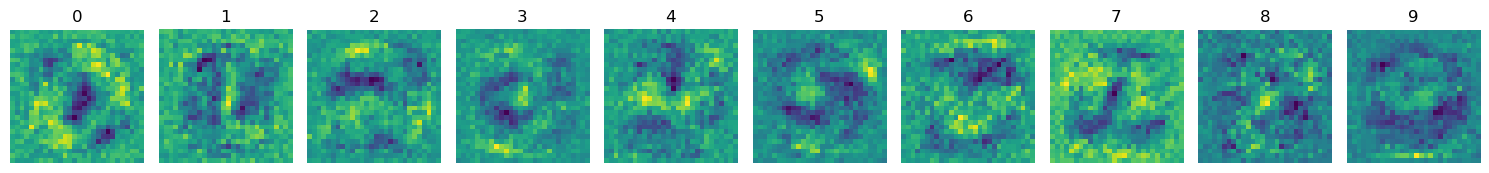

Iteration 28000 current batch loss: 0.002029145834967494
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999595, 0.999694, 0.999699, 0.999728, 0.999651, 0.99973, 0.999627, 0.999741, 0.999461, 0.999613]


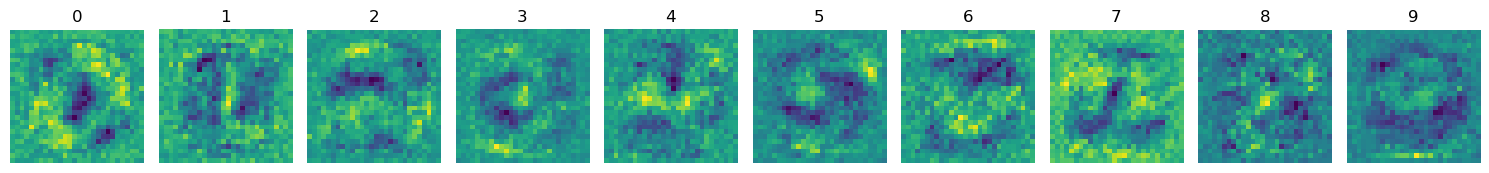

Iteration 30000 current batch loss: 0.0020291535183787346
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999595, 0.999695, 0.999699, 0.999728, 0.999652, 0.99973, 0.999627, 0.999741, 0.999461, 0.999613]


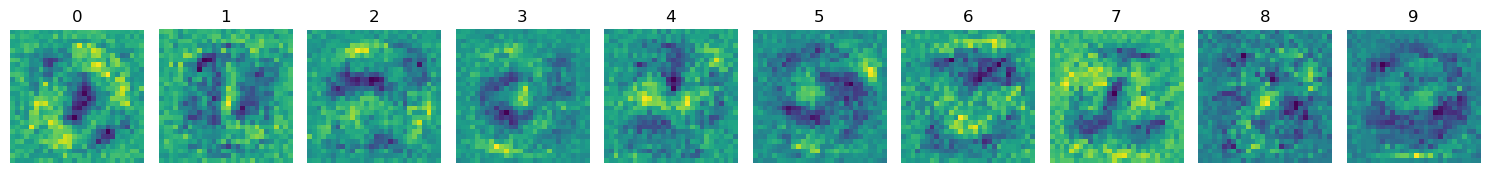

Iteration 32000 current batch loss: 0.0020291616674512625
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999596, 0.999694, 0.999699, 0.999728, 0.999651, 0.999731, 0.999627, 0.999741, 0.999461, 0.999613]


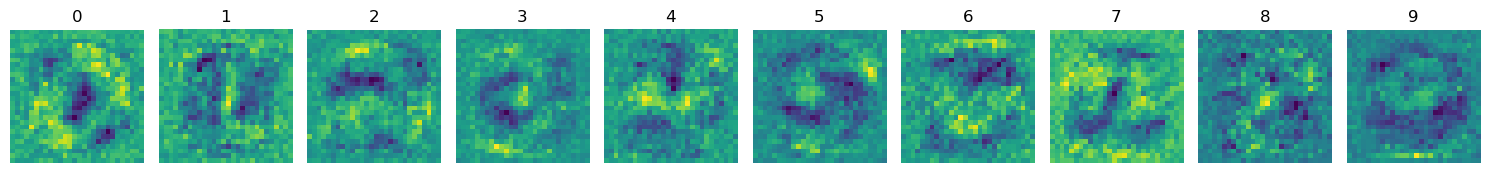

Iteration 34000 current batch loss: 0.002029157243669033
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999595, 0.999694, 0.999699, 0.999728, 0.999652, 0.99973, 0.999627, 0.999741, 0.999461, 0.999613]


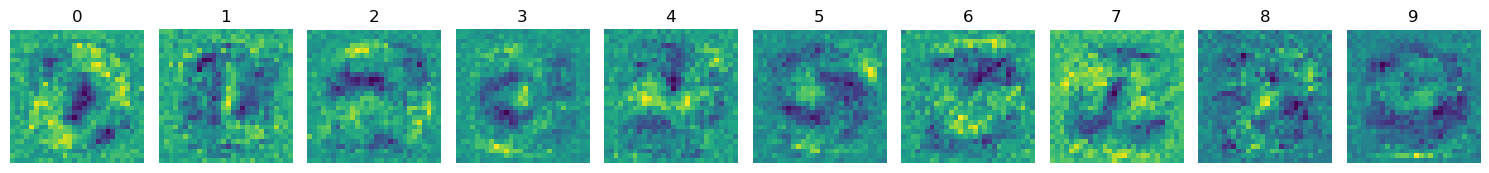

Iteration 36000 current batch loss: 0.0020291598048061132
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999595, 0.999694, 0.999699, 0.999728, 0.999652, 0.999731, 0.999627, 0.999741, 0.999461, 0.999613]


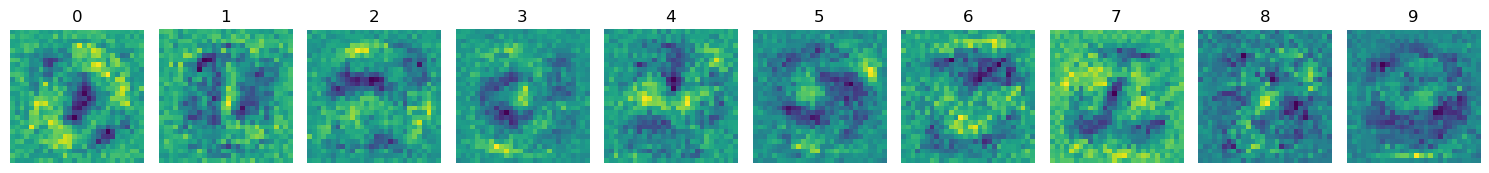

Iteration 38000 current batch loss: 0.002029124414548278
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999595, 0.999694, 0.999699, 0.999728, 0.999652, 0.99973, 0.999627, 0.999741, 0.999462, 0.999613]


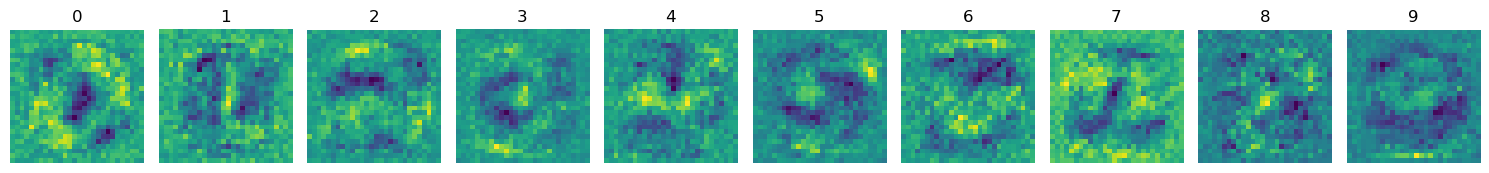

Iteration 40000 current batch loss: 0.0020291598048061132
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.999595, 0.999694, 0.999699, 0.999728, 0.999652, 0.99973, 0.999627, 0.999741, 0.999461, 0.999613]


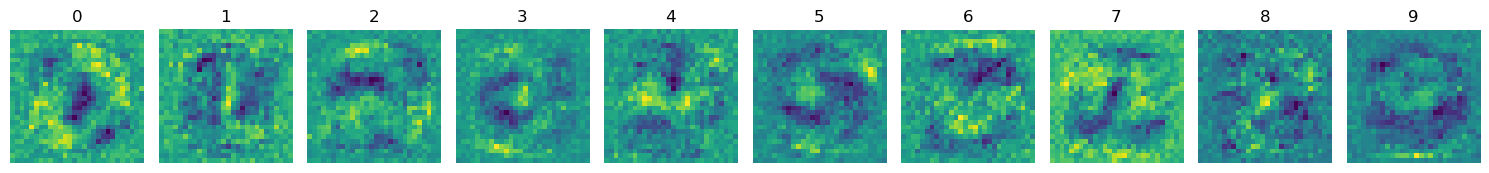

Iteration 40000 current batch loss: 0.0020291598048061132


In [16]:
points_4 = train_input(net, lambda_l2 = 0.1, plot = True)

# Case: $\lambda = 1$

Iteration 2000 current batch loss: 0.3936973810195923
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.995531, 0.99499, 0.996992, 0.996646, 0.996439, 0.996523, 0.993338, 0.995116, 0.991894, 0.995313]


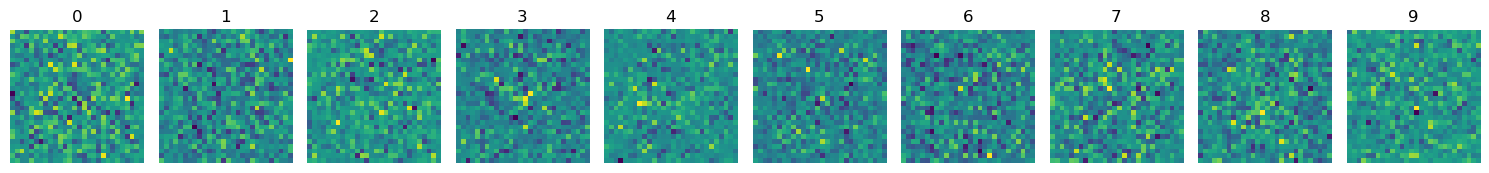

Iteration 4000 current batch loss: 0.08901704102754593
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996268, 0.99674, 0.997498, 0.997698, 0.99723, 0.997682, 0.995929, 0.99741, 0.993973, 0.996541]


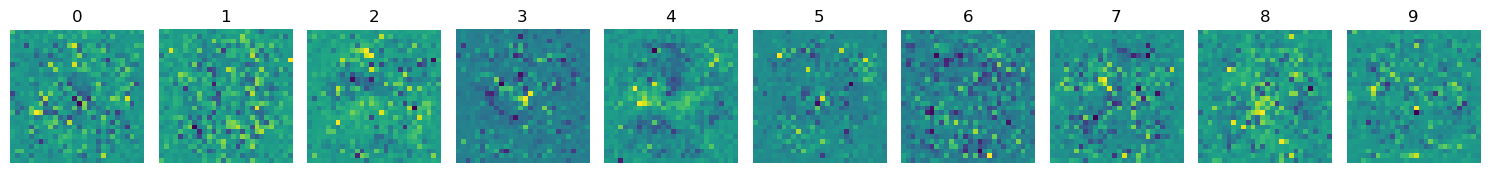

Iteration 6000 current batch loss: 0.019655907526612282
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996682, 0.9974, 0.997611, 0.997846, 0.997276, 0.997844, 0.996665, 0.997898, 0.995115, 0.996899]


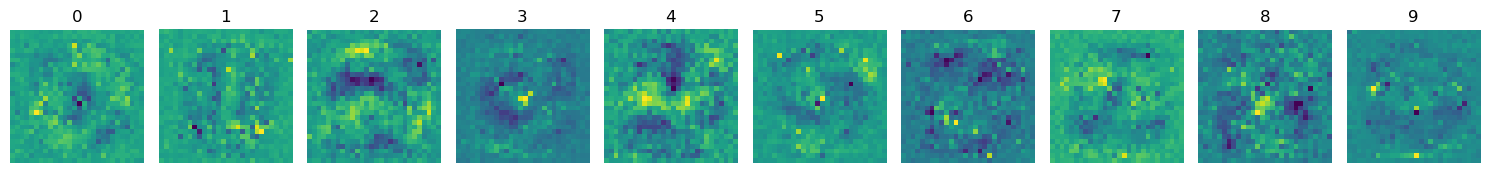

Iteration 8000 current batch loss: 0.013406473211944103
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996809, 0.997544, 0.99764, 0.997863, 0.99728, 0.997879, 0.997075, 0.997989, 0.995622, 0.997001]


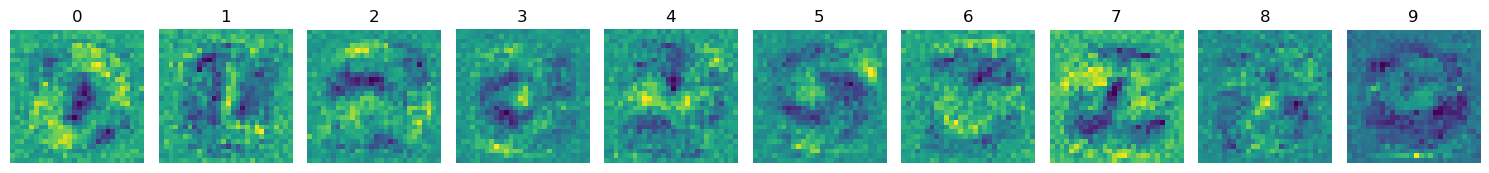

Iteration 10000 current batch loss: 0.01326802559196949
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996814, 0.997596, 0.997641, 0.997861, 0.997277, 0.997882, 0.997092, 0.997995, 0.995658, 0.99699]


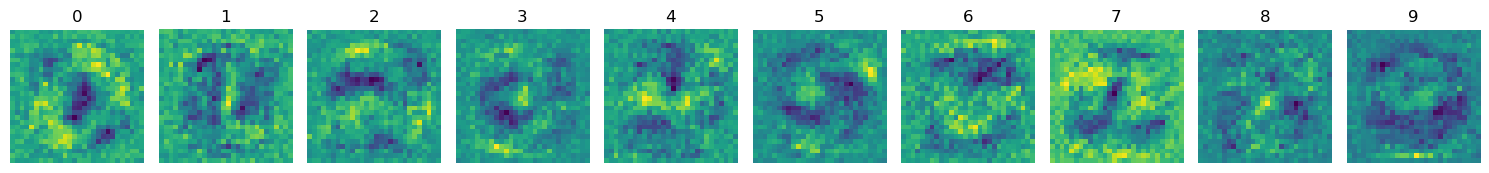

Iteration 12000 current batch loss: 0.013268368318676949
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996814, 0.997596, 0.99764, 0.997861, 0.99728, 0.997883, 0.997093, 0.997995, 0.995658, 0.99699]


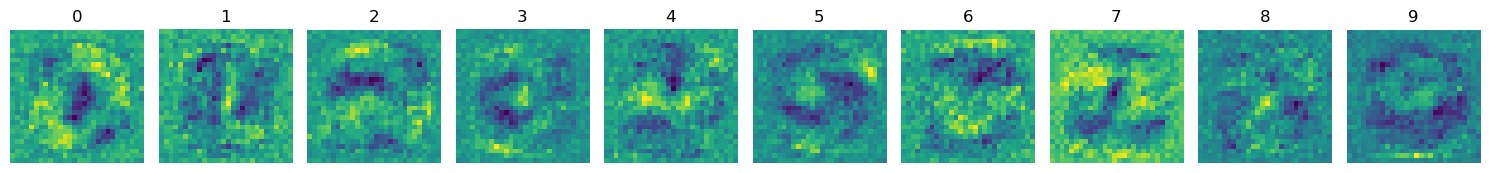

Iteration 14000 current batch loss: 0.013267829082906246
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996816, 0.997595, 0.997641, 0.997861, 0.997285, 0.997885, 0.997093, 0.997994, 0.995658, 0.99699]


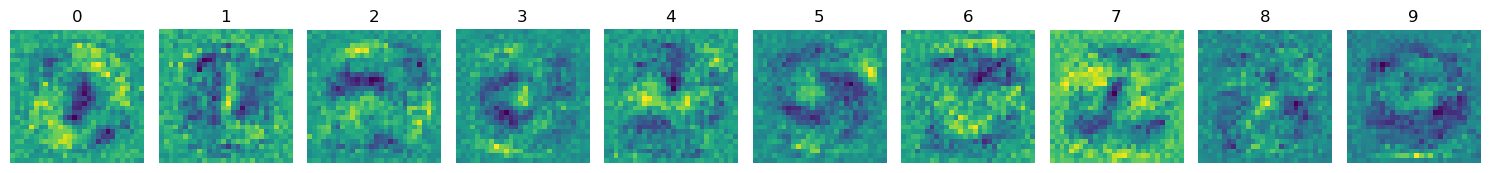

Iteration 16000 current batch loss: 0.013268660753965378
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996814, 0.997595, 0.997642, 0.997861, 0.997271, 0.99788, 0.997093, 0.997993, 0.995659, 0.99699]


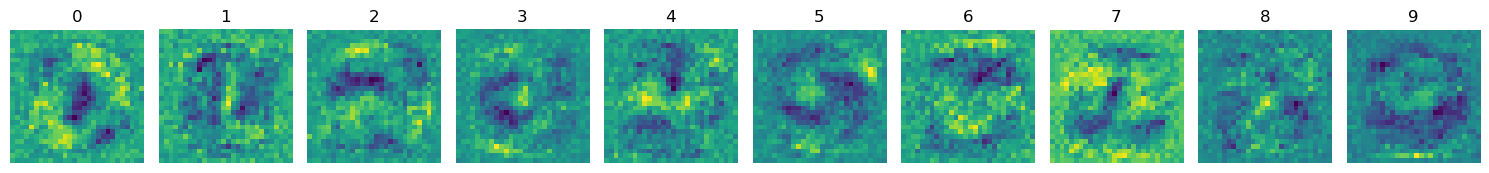

Iteration 18000 current batch loss: 0.01326827798038721
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996816, 0.997594, 0.997638, 0.997861, 0.997277, 0.997879, 0.997092, 0.997994, 0.995658, 0.99699]


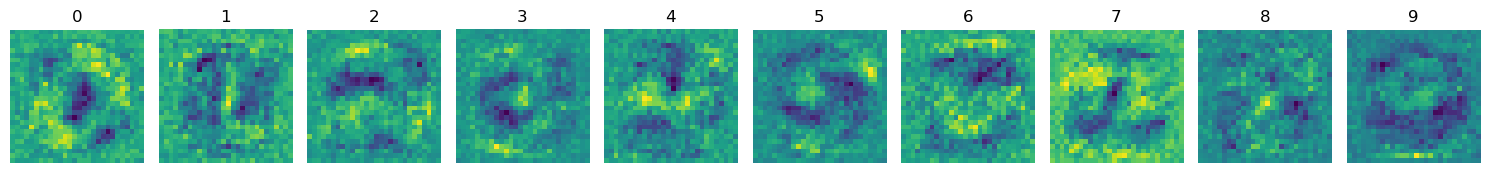

Iteration 20000 current batch loss: 0.013268466107547283
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996817, 0.997596, 0.997642, 0.997861, 0.997281, 0.997884, 0.997093, 0.997994, 0.995659, 0.996989]


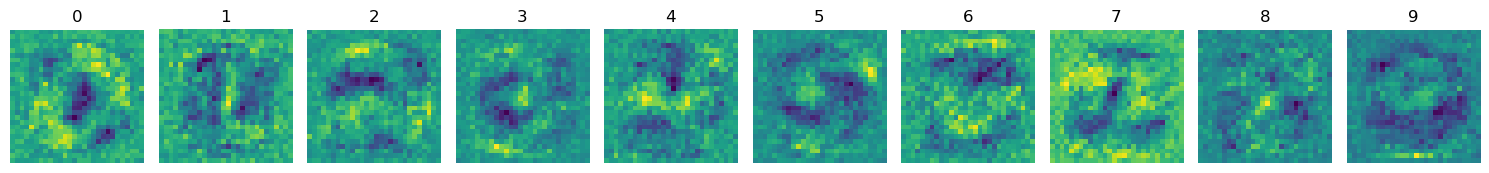

Iteration 22000 current batch loss: 0.013268299400806427
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996814, 0.997596, 0.997641, 0.997863, 0.997279, 0.997883, 0.997093, 0.997995, 0.99566, 0.996992]


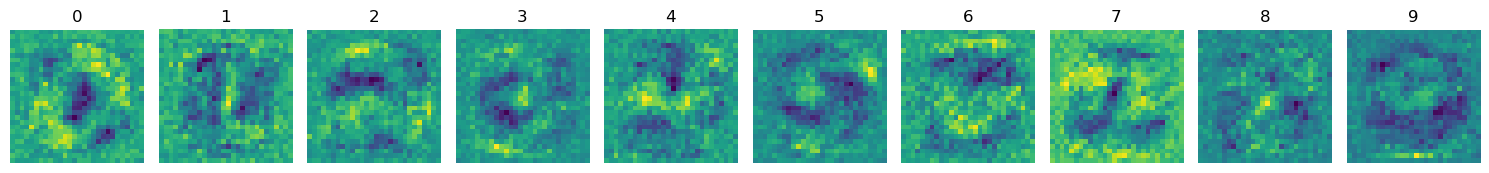

Iteration 24000 current batch loss: 0.013268641196191311
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996816, 0.997594, 0.997641, 0.997861, 0.99728, 0.997879, 0.997091, 0.997996, 0.995655, 0.996991]


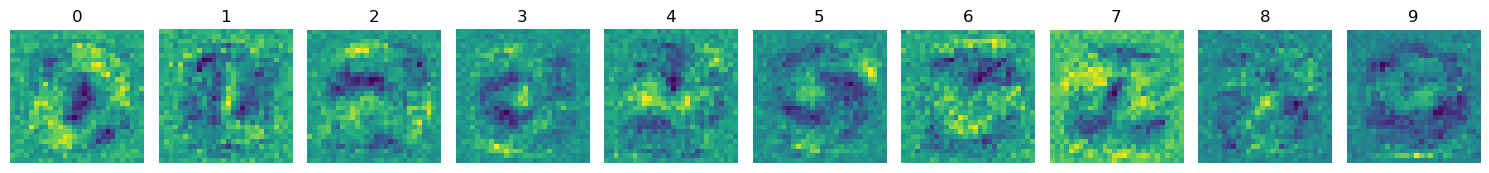

Iteration 26000 current batch loss: 0.013268381357192993
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996816, 0.997596, 0.997641, 0.997862, 0.99728, 0.997879, 0.997091, 0.997994, 0.995657, 0.99699]


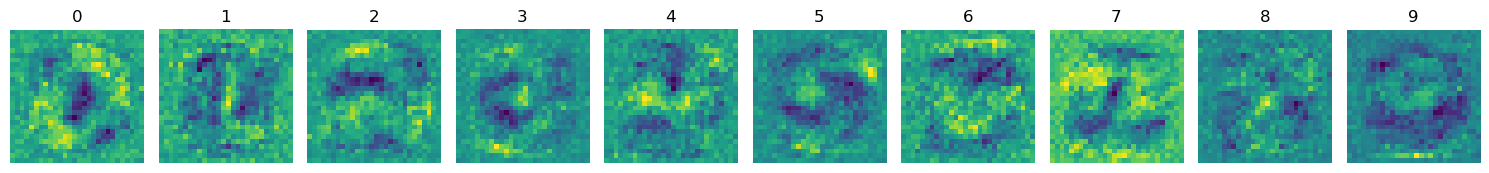

Iteration 28000 current batch loss: 0.013268580660223961
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996816, 0.997593, 0.997642, 0.997863, 0.997278, 0.997876, 0.997091, 0.997995, 0.995657, 0.996991]


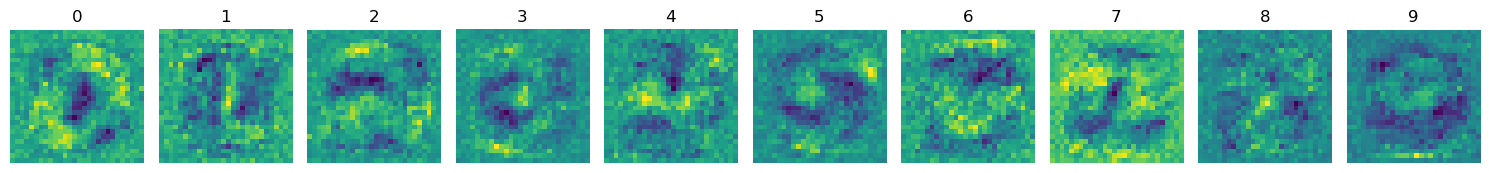

Iteration 30000 current batch loss: 0.013268177397549152
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996818, 0.997597, 0.997641, 0.997862, 0.997279, 0.997881, 0.997092, 0.997994, 0.995657, 0.996991]


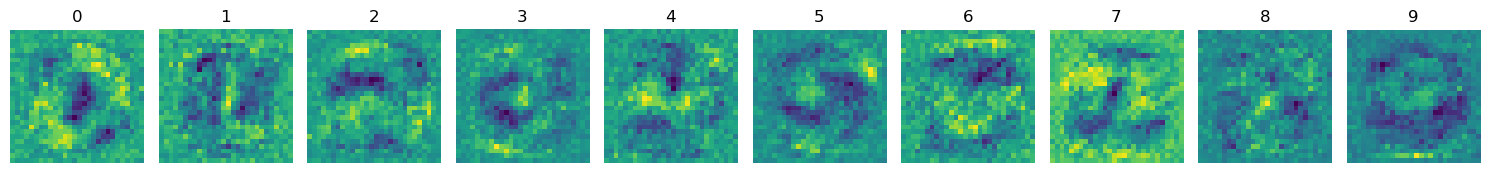

Iteration 32000 current batch loss: 0.013268331065773964
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996813, 0.997595, 0.997642, 0.99786, 0.997284, 0.997881, 0.997093, 0.997996, 0.995659, 0.996992]


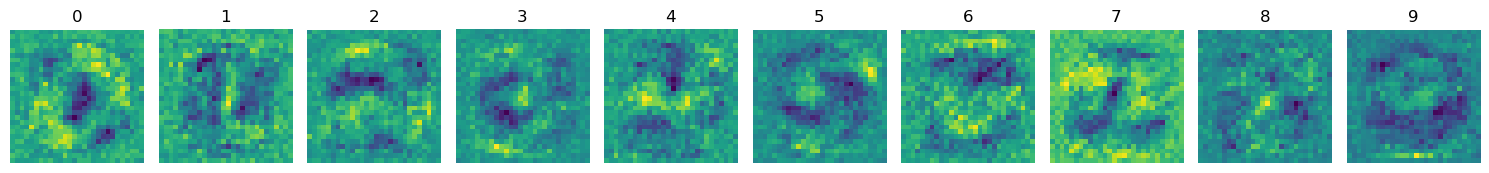

Iteration 34000 current batch loss: 0.013268770650029182
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996816, 0.997597, 0.997641, 0.997862, 0.99728, 0.997878, 0.997093, 0.997992, 0.995659, 0.996991]


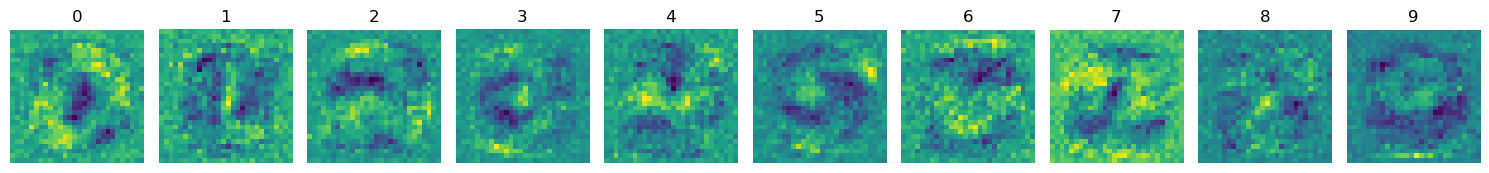

Iteration 36000 current batch loss: 0.01326860673725605
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996815, 0.997594, 0.997642, 0.997862, 0.997279, 0.997883, 0.997092, 0.997995, 0.995661, 0.996991]


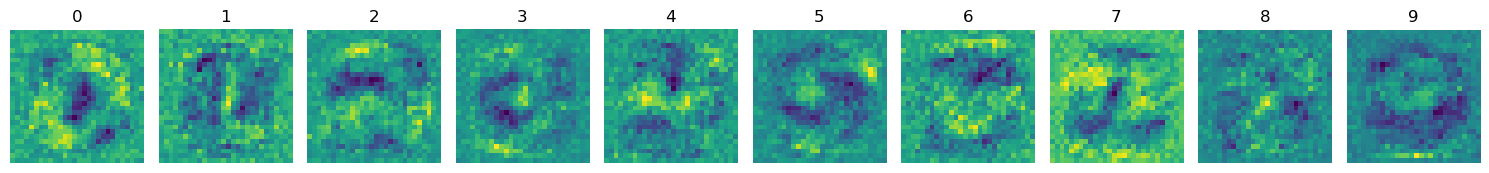

Iteration 38000 current batch loss: 0.01326906867325306
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996816, 0.997594, 0.997641, 0.99786, 0.997279, 0.997881, 0.997091, 0.997995, 0.995656, 0.99699]


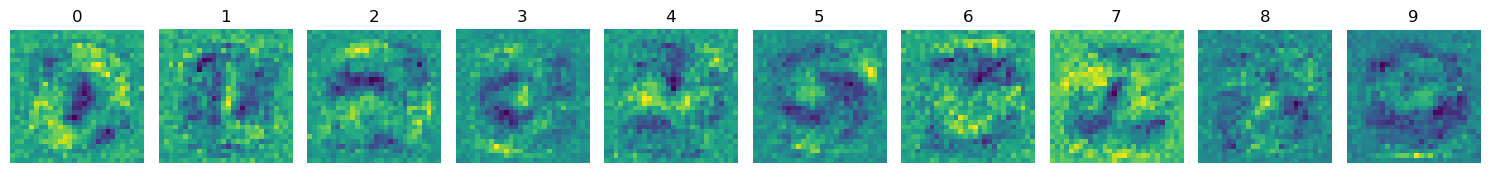

Iteration 40000 current batch loss: 0.01326843537390232
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.996816, 0.997596, 0.997641, 0.997861, 0.997281, 0.997883, 0.997092, 0.997995, 0.995657, 0.996991]


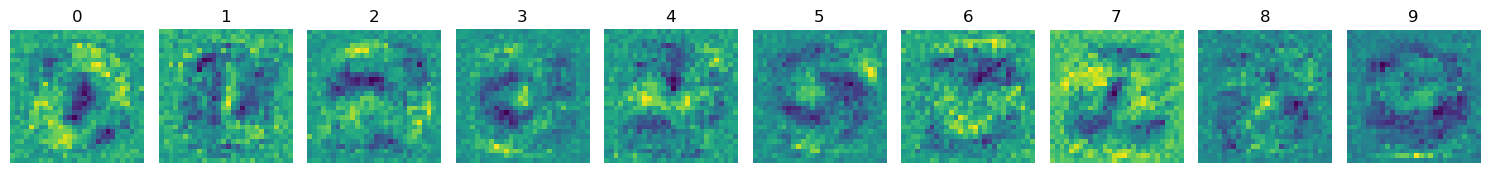

Iteration 40000 current batch loss: 0.01326843537390232


In [17]:
points_5 = train_input(net, lambda_l2 = 1, plot = True)

# Case: $\lambda = 10$

Iteration 2000 current batch loss: 0.8896145224571228
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.975579, 0.976271, 0.974891, 0.98021, 0.971339, 0.979288, 0.968916, 0.978597, 0.943033, 0.966273]


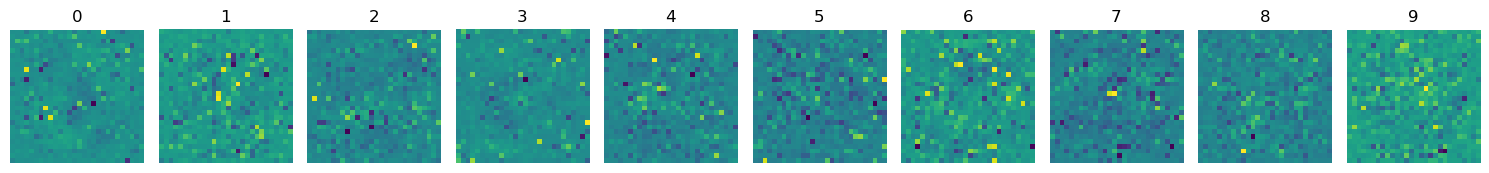

Iteration 4000 current batch loss: 0.10376003384590149
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.976666, 0.980562, 0.982259, 0.983882, 0.979546, 0.983604, 0.977856, 0.984014, 0.963785, 0.975408]


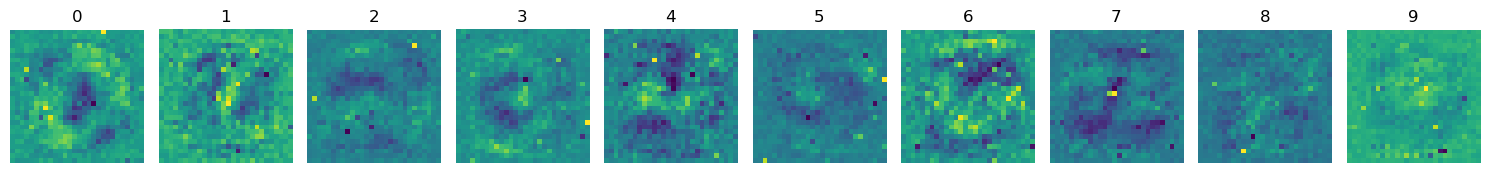

Iteration 6000 current batch loss: 0.0781780481338501
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.976653, 0.982194, 0.982642, 0.984237, 0.980056, 0.984233, 0.978915, 0.985173, 0.969326, 0.97792]


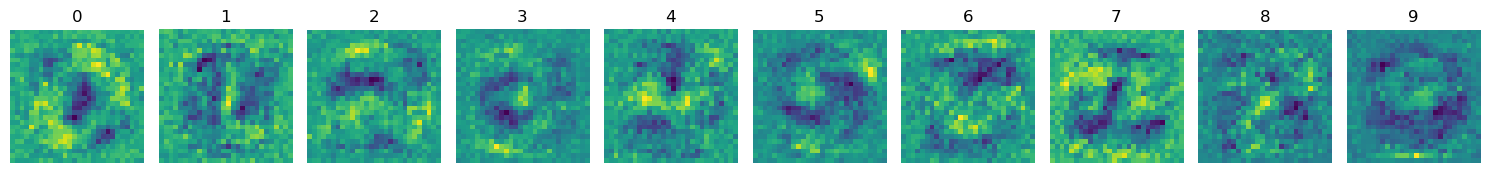

Iteration 8000 current batch loss: 0.07794328033924103
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.976649, 0.982208, 0.982644, 0.984249, 0.980095, 0.984267, 0.978939, 0.985284, 0.96953, 0.978088]


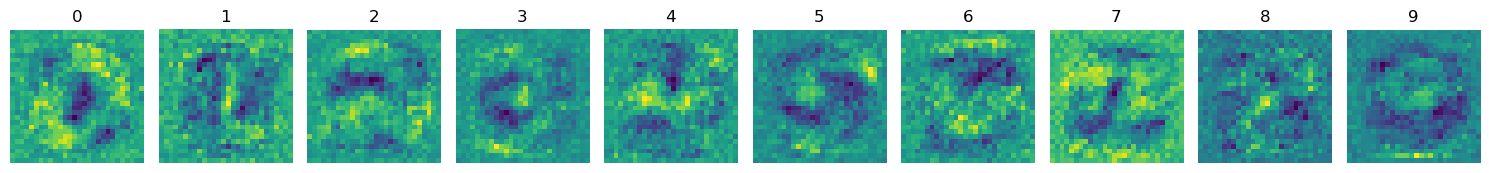

Iteration 10000 current batch loss: 0.07794664800167084
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.97666, 0.98221, 0.982646, 0.984247, 0.980085, 0.984269, 0.978945, 0.985294, 0.969511, 0.97809]


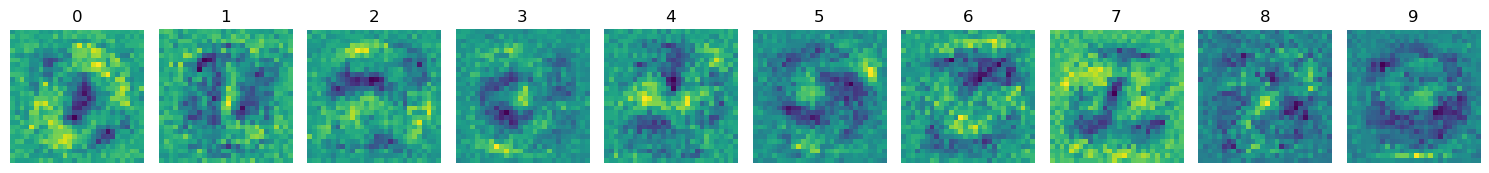

Iteration 12000 current batch loss: 0.0779464840888977
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.97667, 0.9822, 0.982641, 0.984235, 0.980072, 0.984252, 0.978959, 0.985291, 0.969533, 0.978092]


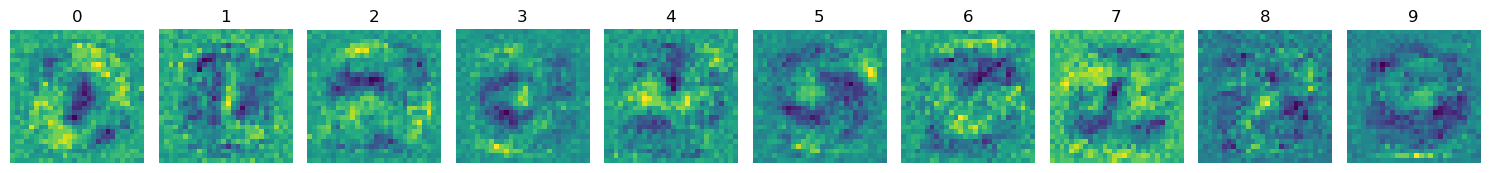

Iteration 14000 current batch loss: 0.0779455304145813
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.976659, 0.982216, 0.982644, 0.984237, 0.980083, 0.984269, 0.978951, 0.985286, 0.969546, 0.97809]


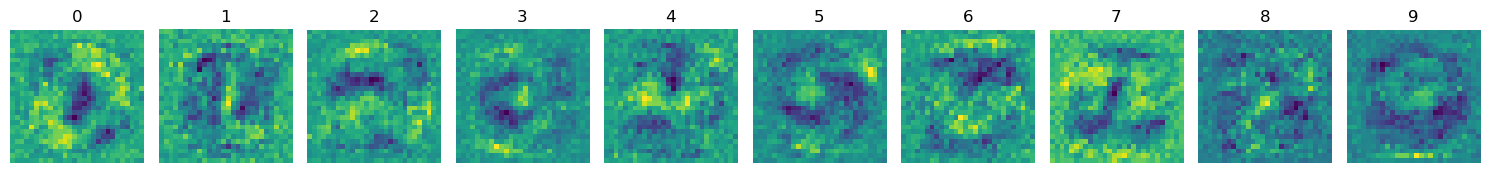

Iteration 16000 current batch loss: 0.07795072346925735
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.976687, 0.982213, 0.982642, 0.984246, 0.980106, 0.98429, 0.978959, 0.985298, 0.969513, 0.978104]


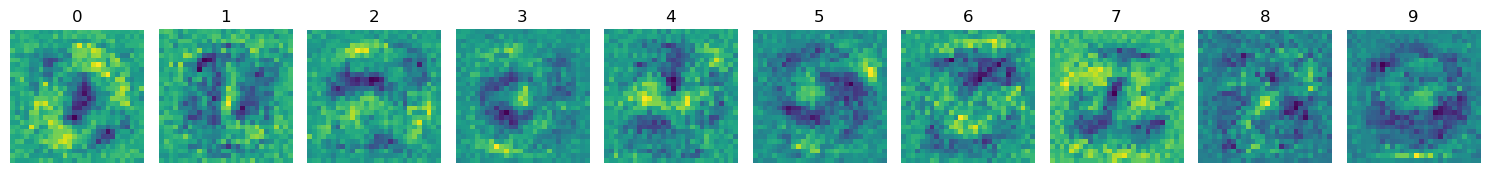

Iteration 18000 current batch loss: 0.07794508337974548
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.97668, 0.982211, 0.982657, 0.984246, 0.980085, 0.984239, 0.978941, 0.985289, 0.969528, 0.978094]


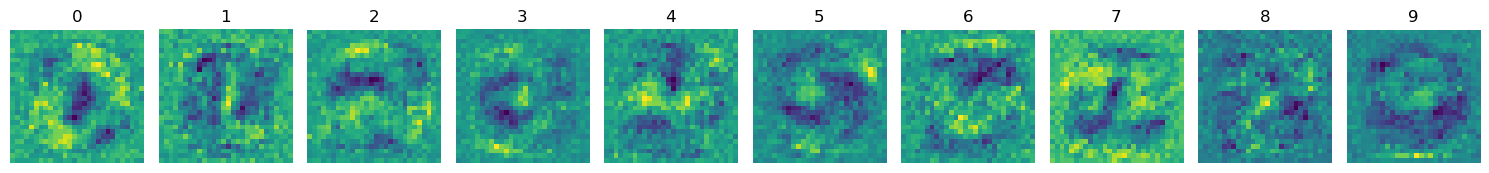

Iteration 20000 current batch loss: 0.07794524729251862
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.976672, 0.982194, 0.982657, 0.98423, 0.980067, 0.984282, 0.978922, 0.985288, 0.969539, 0.978087]


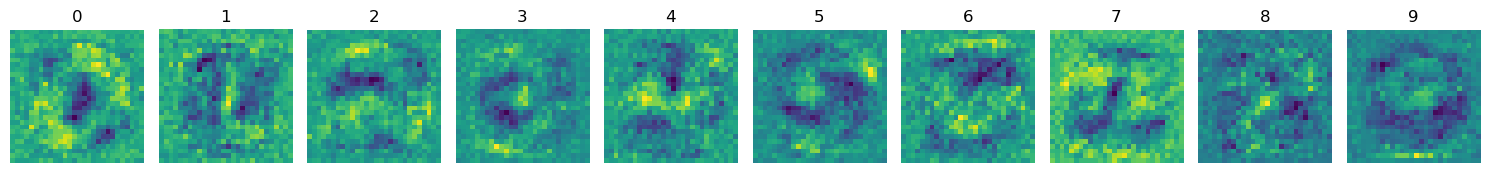

Iteration 22000 current batch loss: 0.07794734835624695
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.976667, 0.982208, 0.982661, 0.984253, 0.980031, 0.984281, 0.978957, 0.98528, 0.969523, 0.978098]


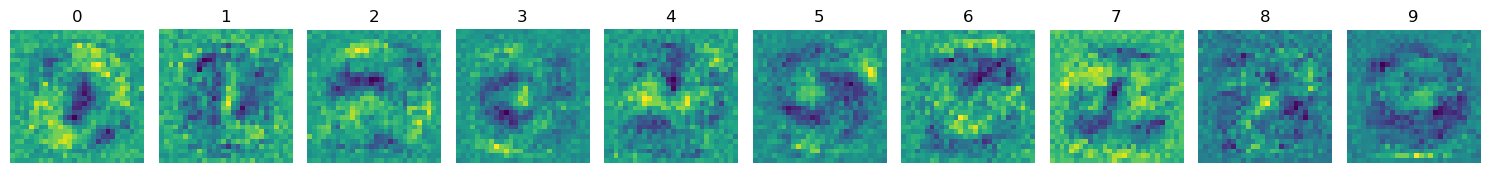

Iteration 24000 current batch loss: 0.07794709503650665
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.976648, 0.982207, 0.982634, 0.984252, 0.980073, 0.984276, 0.978944, 0.985282, 0.96953, 0.978101]


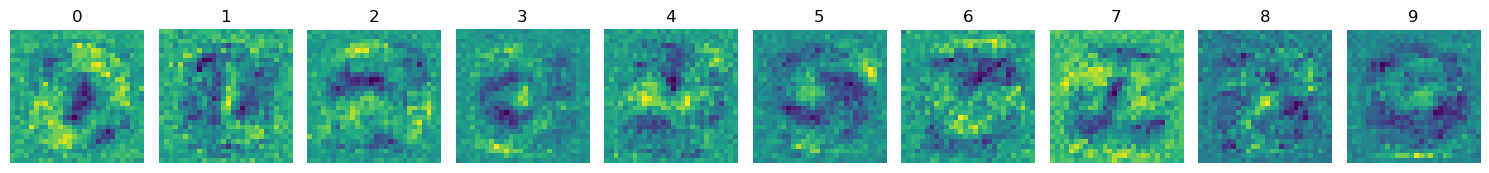

Iteration 26000 current batch loss: 0.07794776558876038
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.976667, 0.982192, 0.982656, 0.984251, 0.980061, 0.984251, 0.978957, 0.985297, 0.969555, 0.978083]


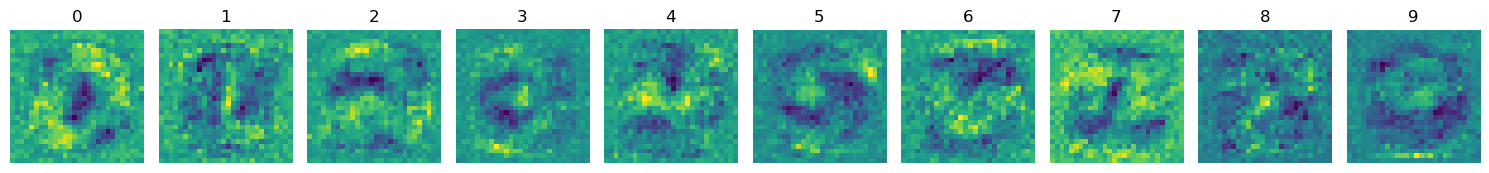

Iteration 28000 current batch loss: 0.07794556021690369
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.97667, 0.98221, 0.982653, 0.984244, 0.980075, 0.984272, 0.978934, 0.985285, 0.969526, 0.978089]


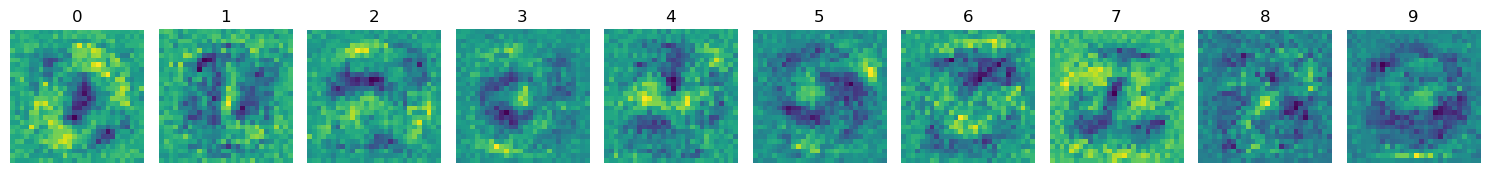

Iteration 30000 current batch loss: 0.07794490456581116
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.976676, 0.982181, 0.982639, 0.98423, 0.980084, 0.984256, 0.978952, 0.985292, 0.969541, 0.978092]


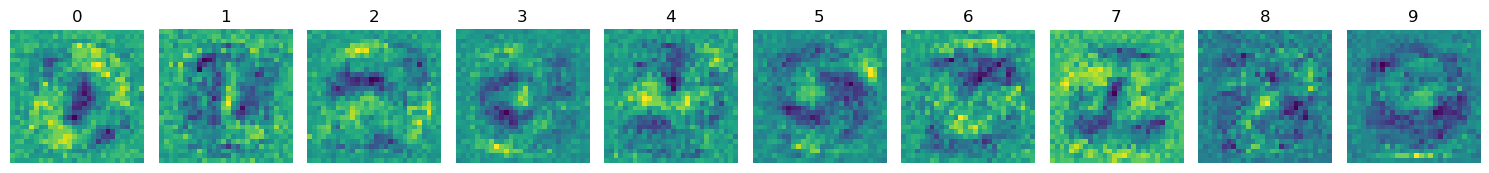

Iteration 32000 current batch loss: 0.07794313877820969
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.976679, 0.982209, 0.982642, 0.984227, 0.980057, 0.984269, 0.978936, 0.985287, 0.969529, 0.978087]


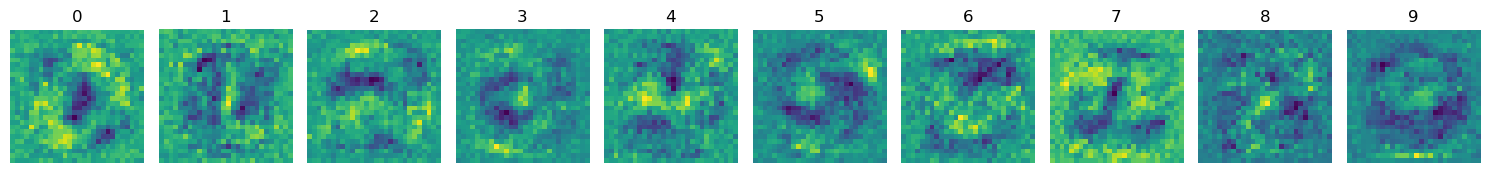

Iteration 34000 current batch loss: 0.07794404774904251
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.976682, 0.982217, 0.982648, 0.98424, 0.980106, 0.984269, 0.978939, 0.98529, 0.969536, 0.978082]


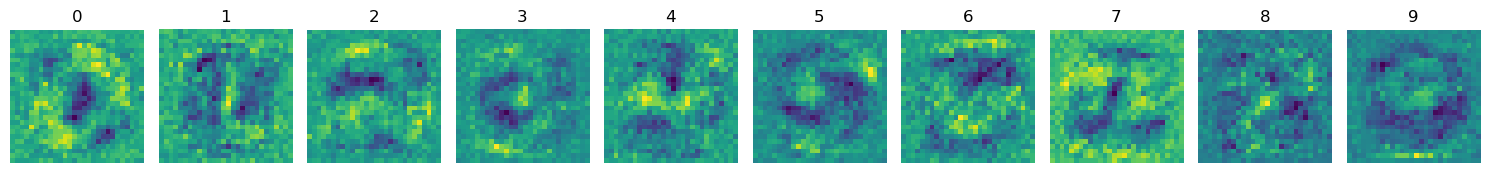

Iteration 36000 current batch loss: 0.07794633507728577
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.97669, 0.982193, 0.982653, 0.984242, 0.980061, 0.984246, 0.978927, 0.985289, 0.969519, 0.978094]


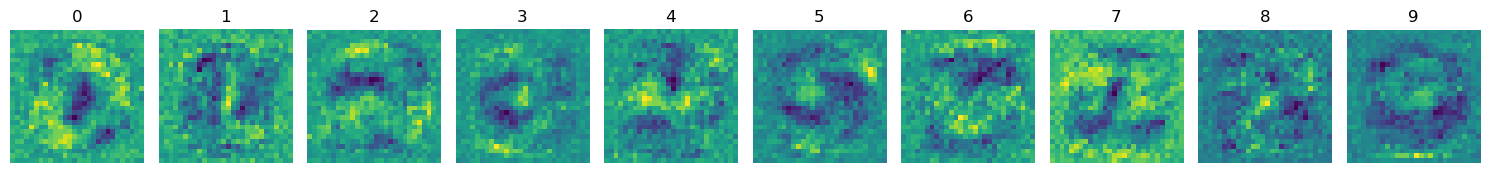

Iteration 38000 current batch loss: 0.07794759422540665
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.976684, 0.982203, 0.98265, 0.984234, 0.980114, 0.984281, 0.978931, 0.985286, 0.969516, 0.978084]


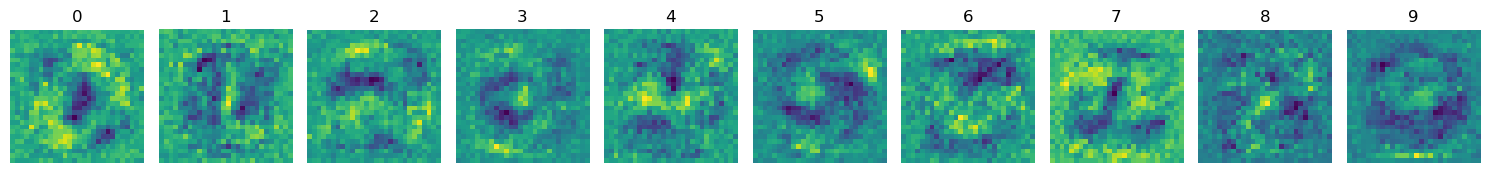

Iteration 40000 current batch loss: 0.07794686406850815
Predicted value:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
 Predicted probability:  [0.976663, 0.9822, 0.98265, 0.984255, 0.980099, 0.98425, 0.978947, 0.985301, 0.969555, 0.978088]


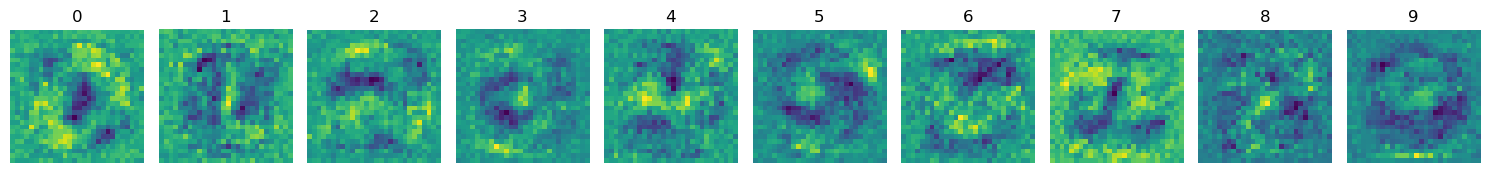

Iteration 40000 current batch loss: 0.07794686406850815


In [18]:
points_6 = train_input(net, lambda_l2 = 10, plot = True)

In [19]:
print("The end!")

The end!


lambda = 0


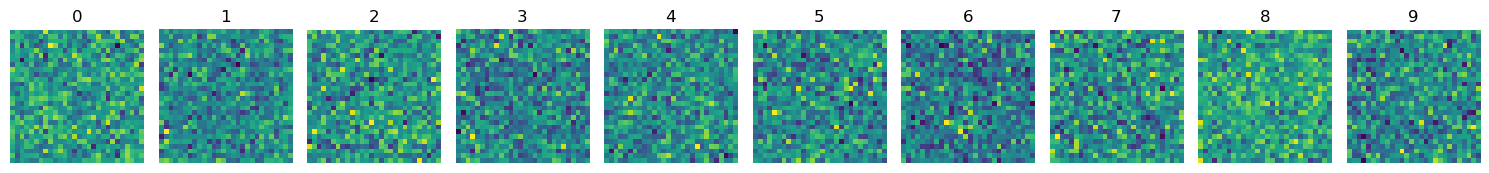

lambda = 0.001


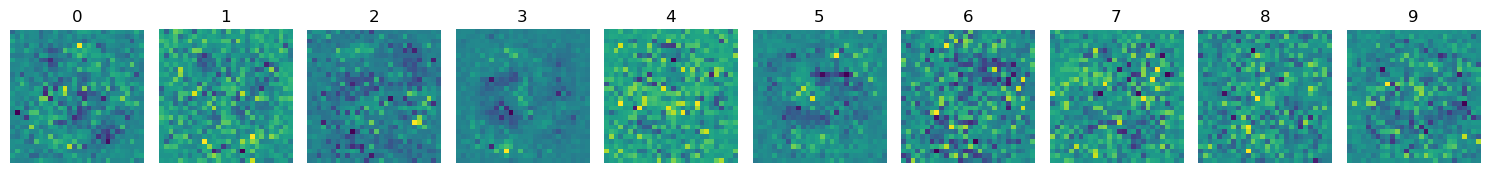

lambda = 0.01


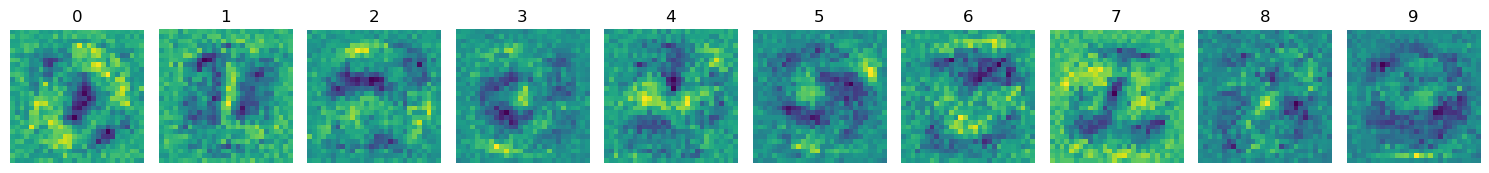

lambda = 0.1


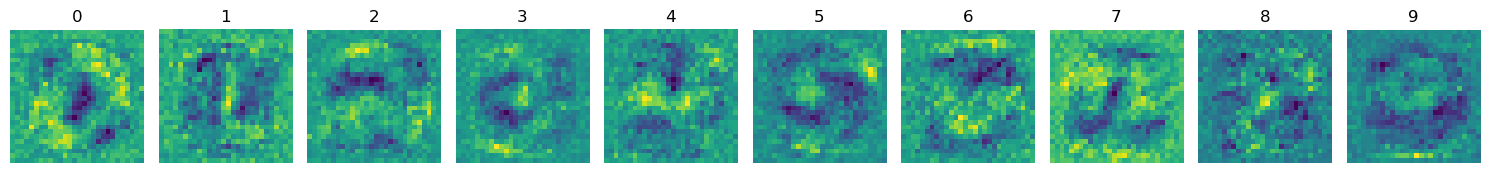

lambda = 1


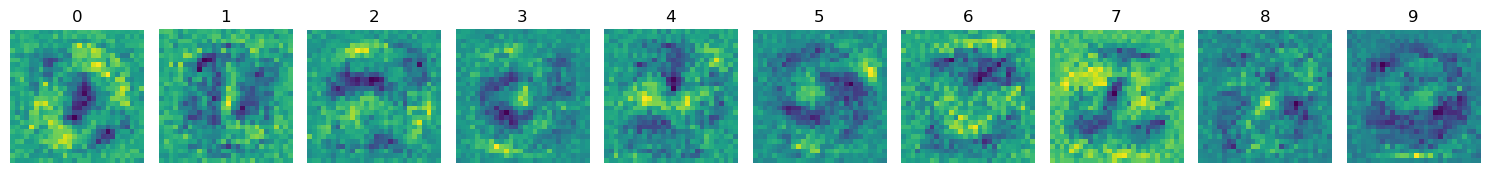

lambda = 10


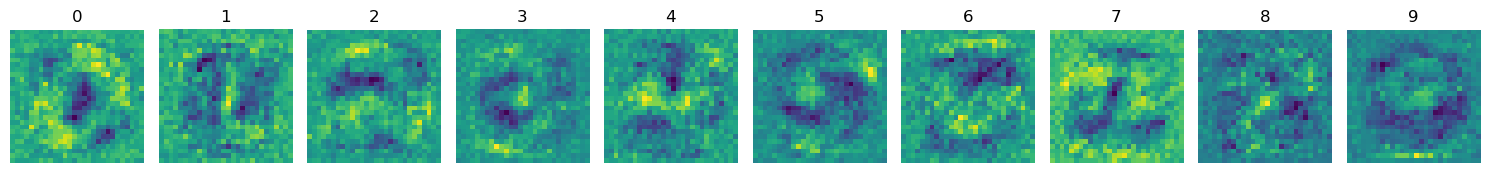

In [20]:
print("lambda = 0")
plot_numbers(points_1)
print("lambda = 0.001")
plot_numbers(points_2)
print("lambda = 0.01")
plot_numbers(points_3)
print("lambda = 0.1")
plot_numbers(points_4)
print("lambda = 1")
plot_numbers(points_5)
print("lambda = 10")
plot_numbers(points_6)   # final plots

# Conclusions

- **Recognizability depends on regularization.** Except when $\lambda = 0$ and $\lambda = 0.001$, the optimized inputs resemble valid MNIST digits. With no regularization ($\lambda = 0$) or with small regularization, the results bear little resemblance to any digit.
- **Model overconfidence at low $\lambda$.** Smaller values of $\lambda$ produce inputs the network classifies with very high confidence—likely because the optimization exploits isolated, distinctive pixels rather than coherent digit shapes.
- **$\lambda$ acts as a smoothing regularizer.** Increasing $\lambda$ encourages smoother, more natural-looking digit patterns by penalizing extreme pixel values.



# Creating two or more similar numbers

Let's focus on task of generating an image that bares similarity to two or more digits simultaneously. To accomplish this, we’ll define a loss function that is the sum of the cross-entropy losses for each digit that our generated image is meant to resemble.

In [21]:
def plot_similar_numbers(points):   # function for plotting

    img = points.squeeze().detach().cpu().numpy()
    pyplot.imshow(img)                 
    pyplot.tight_layout()
    pyplot.show()

def train_input_similar_numbers(net, numbers, lambda_l2 = 0, lr = 0.001, plot = False, info = 2000, max_iter = 40000):
    
    net.eval()
    for parameters in net.parameters():
        parameters.requires_grad = False   # freezing model
    
    points = torch.randn(1, 1, 28, 28).to(device)
    points.requires_grad = True   # creating random noise
        
    optimizer = torch.optim.Adam([points], lr)   

    epoch = 0
    
    while epoch < max_iter:
    
        loss = 0
        optimizer.zero_grad()
        preds = net(points)
        for number in numbers:
            true = torch.tensor([number], dtype=torch.long, device=device)
            loss += torch.nn.functional.cross_entropy(preds, true, reduction = "mean") + lambda_l2 * points.pow(2).mean()   # definition of our loss function
    
        epoch += 1
        if epoch % info == 0:
            print("Iteration", epoch, "current batch loss:", loss.item())
            preds_list = torch.nn.functional.softmax(net(points), dim = 1).tolist()[0]
            print("Predicted probabilities: ", [round(pred, 6) for pred in preds_list])
            if plot:
                plot_similar_numbers(points)
        
        loss.backward()     
        optimizer.step()     

    print("Iteration", epoch, "current batch loss:", loss.item())

    for parameters in net.parameters():
        parameters.requires_grad = True
        
    return points

Iteration 2000 current batch loss: 2.322627305984497
Predicted probabilities:  [0.489363, 0.000154, 0.005527, 0.001677, 0.000178, 0.00296, 0.004865, 0.000399, 0.4903, 0.004577]


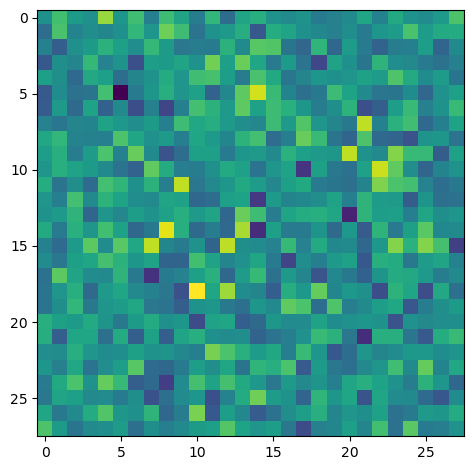

Iteration 4000 current batch loss: 1.6569132804870605
Predicted probabilities:  [0.493034, 0.000141, 0.003904, 0.000964, 0.000168, 0.001862, 0.003082, 0.000386, 0.493278, 0.00318]


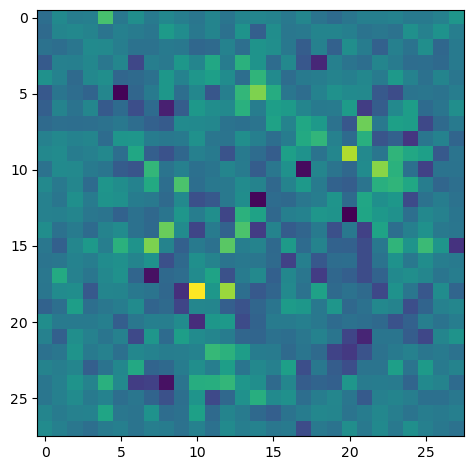

Iteration 6000 current batch loss: 1.4833123683929443
Predicted probabilities:  [0.494719, 0.000172, 0.002982, 0.000561, 0.000247, 0.001266, 0.002469, 0.000568, 0.49453, 0.002485]


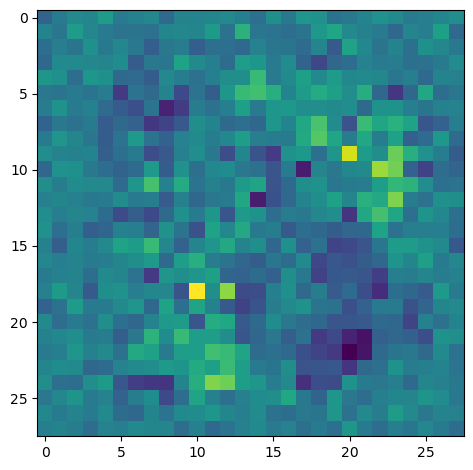

Iteration 8000 current batch loss: 1.462558388710022
Predicted probabilities:  [0.494975, 0.000189, 0.002728, 0.000464, 0.000261, 0.001206, 0.002229, 0.000549, 0.495016, 0.002382]


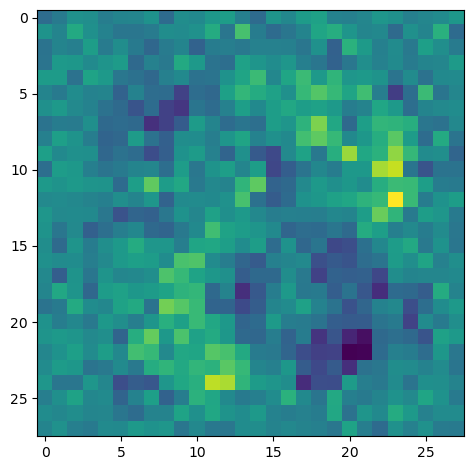

Iteration 10000 current batch loss: 1.4620271921157837
Predicted probabilities:  [0.495165, 0.000191, 0.002709, 0.000456, 0.000257, 0.001224, 0.002197, 0.000535, 0.494923, 0.002341]


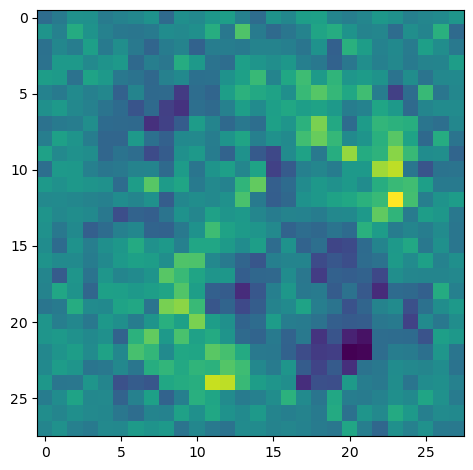

Iteration 12000 current batch loss: 1.462027907371521
Predicted probabilities:  [0.495509, 0.000191, 0.00271, 0.000456, 0.000257, 0.001224, 0.002197, 0.000534, 0.49458, 0.002341]


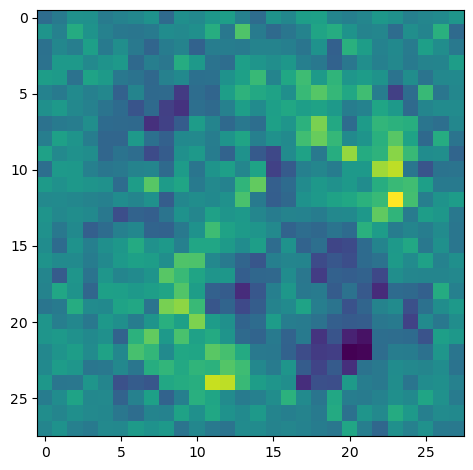

Iteration 14000 current batch loss: 1.4620354175567627
Predicted probabilities:  [0.496125, 0.000191, 0.002714, 0.000456, 0.000257, 0.001225, 0.002193, 0.000534, 0.493964, 0.002339]


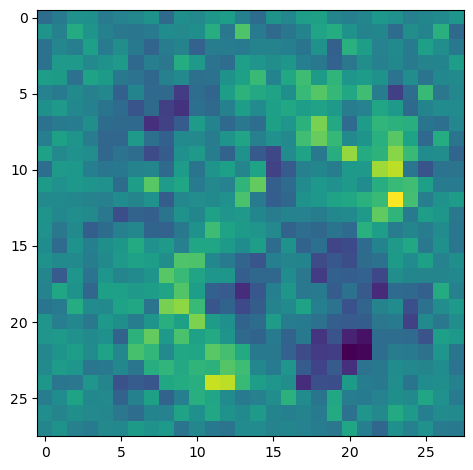

Iteration 16000 current batch loss: 1.4620330333709717
Predicted probabilities:  [0.496155, 0.000191, 0.002709, 0.000456, 0.000257, 0.001224, 0.002197, 0.000535, 0.493936, 0.00234]


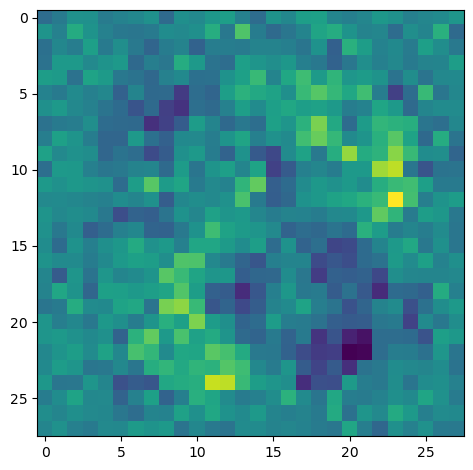

Iteration 18000 current batch loss: 1.4620310068130493
Predicted probabilities:  [0.494679, 0.000191, 0.002711, 0.000456, 0.000257, 0.001226, 0.002197, 0.000534, 0.495408, 0.00234]


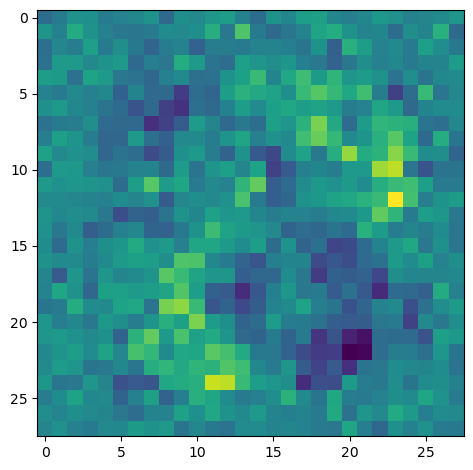

Iteration 20000 current batch loss: 1.4620451927185059
Predicted probabilities:  [0.493207, 0.000192, 0.00271, 0.000456, 0.000258, 0.001225, 0.002196, 0.000535, 0.49688, 0.002341]


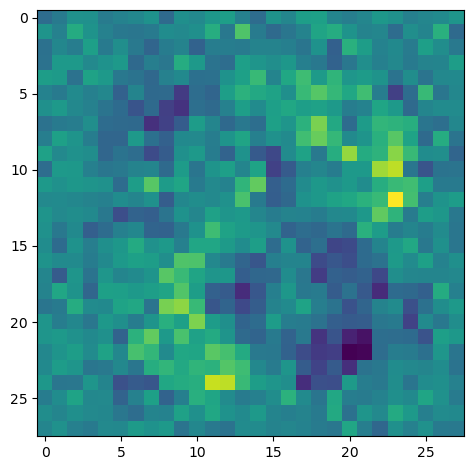

Iteration 22000 current batch loss: 1.4620277881622314
Predicted probabilities:  [0.49512, 0.000191, 0.002709, 0.000456, 0.000257, 0.001223, 0.002195, 0.000534, 0.494975, 0.002341]


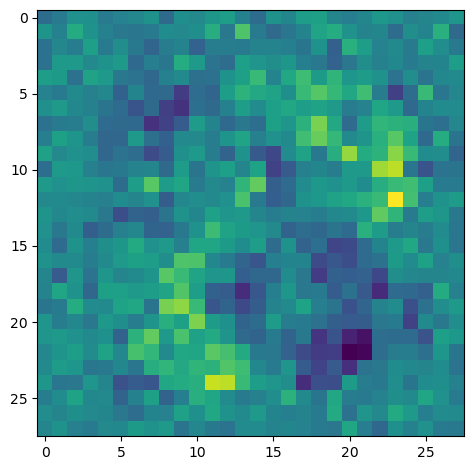

Iteration 24000 current batch loss: 1.4620361328125
Predicted probabilities:  [0.496354, 0.000191, 0.002711, 0.000456, 0.000257, 0.001224, 0.002196, 0.000534, 0.493736, 0.00234]


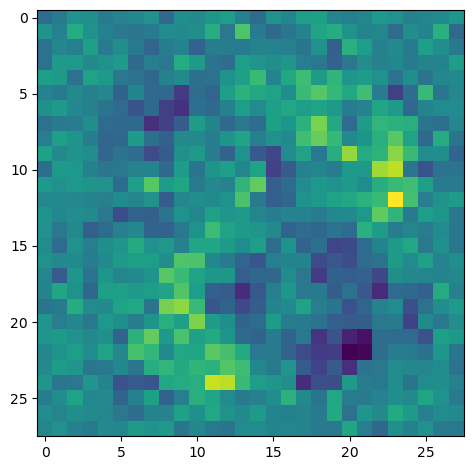

Iteration 26000 current batch loss: 1.4620295763015747
Predicted probabilities:  [0.495276, 0.000191, 0.002713, 0.000456, 0.000257, 0.001223, 0.002197, 0.000535, 0.494814, 0.002339]


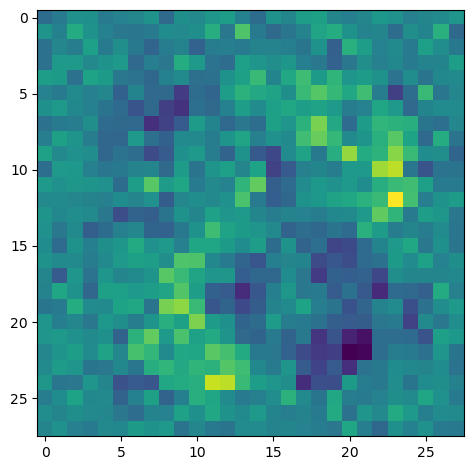

Iteration 28000 current batch loss: 1.4620318412780762
Predicted probabilities:  [0.494536, 0.000191, 0.002711, 0.000456, 0.000258, 0.001223, 0.002198, 0.000535, 0.495554, 0.002338]


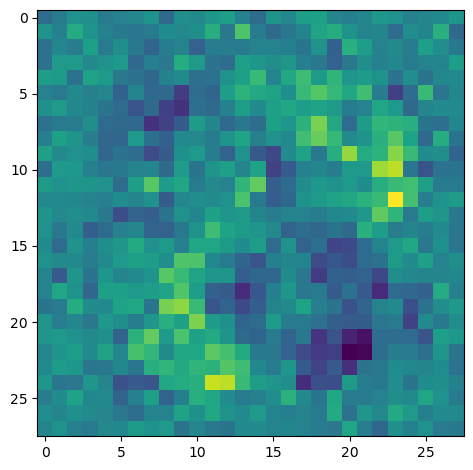

Iteration 30000 current batch loss: 1.462028980255127
Predicted probabilities:  [0.4952, 0.000191, 0.00271, 0.000456, 0.000257, 0.001226, 0.002197, 0.000535, 0.494886, 0.002341]


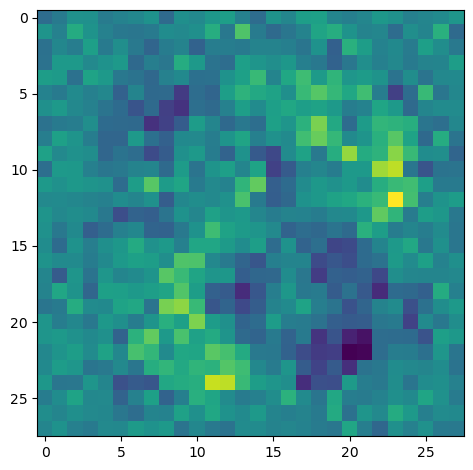

Iteration 32000 current batch loss: 1.4620317220687866
Predicted probabilities:  [0.495665, 0.000191, 0.002709, 0.000457, 0.000257, 0.001226, 0.002196, 0.000535, 0.494419, 0.002343]


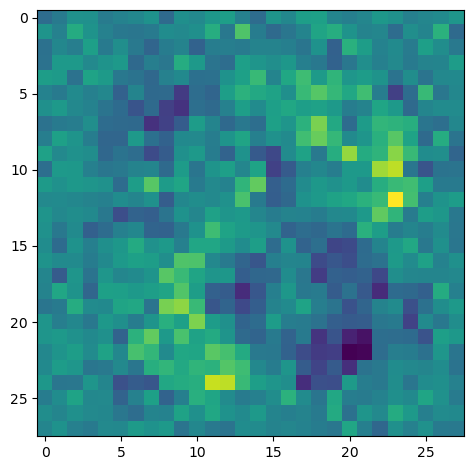

Iteration 34000 current batch loss: 1.4620375633239746
Predicted probabilities:  [0.493746, 0.000191, 0.002712, 0.000456, 0.000257, 0.001225, 0.002194, 0.000534, 0.496344, 0.002341]


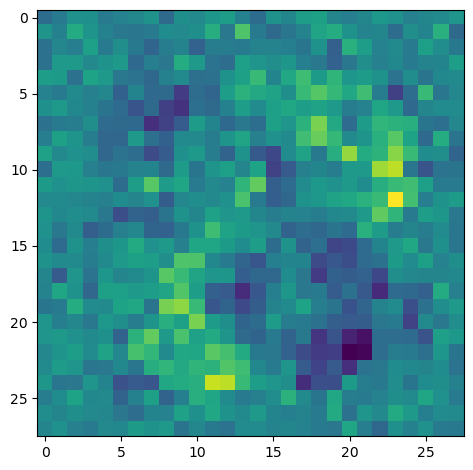

Iteration 36000 current batch loss: 1.4620318412780762
Predicted probabilities:  [0.494735, 0.000192, 0.002712, 0.000456, 0.000258, 0.00122, 0.002198, 0.000536, 0.495359, 0.002334]


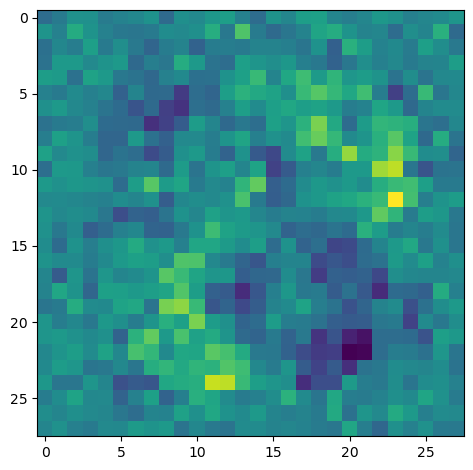

Iteration 38000 current batch loss: 1.4620307683944702
Predicted probabilities:  [0.495309, 0.000191, 0.002713, 0.000456, 0.000257, 0.001224, 0.002197, 0.000534, 0.49478, 0.002338]


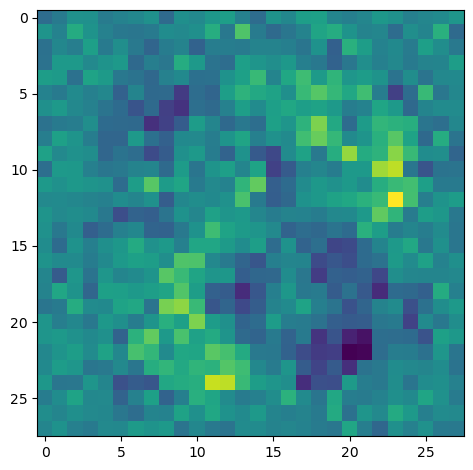

Iteration 40000 current batch loss: 1.4620332717895508
Predicted probabilities:  [0.496105, 0.000191, 0.002713, 0.000457, 0.000257, 0.001223, 0.002196, 0.000535, 0.493985, 0.002338]


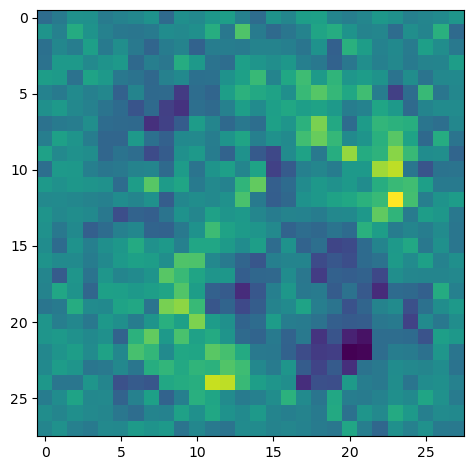

Iteration 40000 current batch loss: 1.4620332717895508


In [22]:
points = train_input_similar_numbers(net, [0, 8], lambda_l2 = 1, plot = True)

In [23]:
print("The end!")

The end!


# Conclusions

Unfortunately, our number is not recognisable for us, but for the model the image bares similarity to two previously defined numbers. The model predicts the probability of 0 and 8 to be equal approximately 0.5. 